# Exploring Low-Dimensional Manifolds with Disentangling Flow Models

### Introduction
Suppose you have a high-dimensional dataset whose structure you are aiming to understand. For instance, you might be trying to interpret image data capturing people's faces or sound-data collecting voice recordings. If you are working with multi-layered artificial neural networks, you might have a latent representation that must capture something intermediate to the stimulus modality and abstract semantics. All these examples have in common that the data is a collection of instances and each such instance is defined as a point in a high-dimensional space. The points form a cloud (also known as manifold) that likely has a complicated shape. Yet, some regions of the point-cloud group certain instances and this grouping corresponds to a human-understandable concept or factor. 


In the case of facial images, this could be the size of a nose, the color of the eyes or whether someone is wearing a hat:

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Images%20of%20Face%20Parts.png?raw=true" width="600"/>

For image references click [left](https://cdn.mos.cms.futurecdn.net/5HYdrDsenbowySwd8WnARf-1000-80.jpg), [middle](https://lh5.googleusercontent.com/proxy/eFWeUzmakVUxfVZN2UPILcGjEV3x-WXLW-Bof9ReHUxYSxby4Mbu8kIi_WKZ_T14ZboJmXR2NRWLL17t3lrEyFPxNhhdlwFLqX9mj8ODz0zPinjhDmEqWOZcYukFbf2WQ-h-k8uGBnvwIfhz0iUnBWspIA), [right](https://www.monsoon.co.uk/dw/image/v2/BDLV_PRD/on/demandware.static/-/Sites-monsoon-master-catalog/default/dwc17cd212/images/large/21_20018770015_1.jpg?sw=663&sh=848&sm=cut)

For the voice-recordings, this could be whether it is a male or female voice or whether an adult or a child is speaking. 

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Images%20of%20Mouths.png?raw=true" alt="images of mouths" width="600"/>

For image reference, click [left](https://www.shutterstock.com/image-photo/closeup-male-mouth-healthy-smile-260nw-1564211686.jpg), [middle](https://img.pixers.pics/pho_wat(s3:700/FO/41/73/45/67/700_FO41734567_dddf4884ecfea4f8a5fcf19114d4c28c.jpg,700,467,cms:2018/10/5bd1b6b8d04b8_220x50-watermark.png,over,480,417,jpg)/stickers-smiling-woman-mouth-with-great-teeth-over-white-background.jpg.jpg"), [right](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSvids2TtwliedPRuR9nYemP25-HtlFL67Orw&s")

To better understand the structure of a manifold, we thus need to project it to a lower dimensional space for which it is easier to reason about. While linear projection methods such as principal component analysis are widely used, they only allow to reshape a manifold by moving, shearing, flipping or rotating it. Apart from that, it is biased towards the dominant axes of variance, while these might not always be the factor of interest to you. More advanced non-linear projection methods like t-distributed stochastic neighborhood embeddings (t-SNE), uniform manifold approximations and projections (UMAPs) or artificial neural networks (ANNs) can morph space by squeezing some parts more than others. However, t-SNE and UMAP are not invertible and ANNs would need a mirrored version of themselves to approximate their own inverse. This requires more model parameters, training resources and is inaccurate.

In this interactive notebook, we will learn about supervised disentangling flow models that can compute a non-linear mapping from a high-dimensional space to a low-dimensional one and thus allow to test for and visualize certain structures thought to underly the given high-dimensional manifold. Due to their trivial invertibility, these flow models allow to map systematic changes made in the disentangled space back onto the original space. 

While the ultimate goal is, of course, to work with high-dimensional manifolds like yours, this notebook aims to equip you with an intuition for the mechanisms underlying this disentanglement technique. In order to establish this intuition, the notebook will use simple 2-dimensionsional case studies to test the models' abilities to deal with rotations, non-linear stretching or discontinuities. For instance, the swirl that is shown in the below image on the left. For this manifold, one could argue that there is only one meaningful factor and that is a point's position along the swirl. The goal would thus be to map from the 2-dimensional space to a 1-dimensional space that captures this factor. For the first case studies, simple models will be demonstrated while later case studies use more advanced models. The results are evaluated quantitatvely and discussed. Due to the interactive nature of this notebook, it is possible for the reader to  change experimental configurations and thus verify the observations made here. In order to build the flow models, the software package [gyoza](https://pypi.org/project/gyoza/) will be used. Readers who are unfamiliar with this toolbox can read its [documentation](https://gyoza.readthedocs.io/en/latest/index.html) alongside this tutorial. For readers who intend to embed gyoza's flow models into their own processing pipelibe, further tutorials can be found on the project's [GitHub](https://github.com/TimHenry1995/gyoza) page.

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Manifold%20Disentanglement%20Cartoon.png?raw=true" alt="drawing" width="600"/>



### Formal Description of the Problem
The overall objective is to develop an invertible model $T$ that maps an arbitrary point-cloud $Z \in \mathbb{R}^{M \times N}$ to a disentangled one $\tilde{Z} \in \mathbb{R}^{M \times N}$ with meaningful axes, where $M, N \in \mathbb{N}$ are the instance and dimension counts, respectively. For this purpose, it is necessary to define factors $k \in \{0,1,...,F\}$, for $F \in \mathbb{N}$ that capture an attribute of the point cloud, such as position along the manifold, or deviation away from it. A point $z \in \mathbb{R}^N$ in the cloud can thus be described by a corresponding model ouput $\tilde{z} \in \mathbb{R}^N$ that expresses its scores along these factors. That is, each factor will have a certain set of dimensions in $\tilde{z}$ that encode its and only its meaning. By convention, the factor at index 0 is the residual factor capturing all unknown variation in the data (here deviation from the manifold) and is set to 0 for convenience. In the here provided 2-dimensional case studies, factor 0 is assigned the output dimension 0. The factor at index 1 is here supervised as the position $s \in \mathbb{R}$ along the manifold. This factor is assigned dimension 1 of the output. Together, the two factors thus describe all of 2-dimensional space. However, in these case studies, we are primarily interested in factor 1 and its dimenions (1). The model learns from pairs of instances ($z_a, z_b$) whose similarity along the factors has to be provided such that it can construct a mapping that preserves proximities. The below diagram illustrates the input and output as well as the role of the model for training and inference.

<img src="https://github.com/TimHenry1995/gyoza/blob/develop/docs/images/Input%20and%20Output%20Diagram.png?raw=true" alt="input output diagram" width="600"/>

The below table collects all terms that carry special meaning here. Lowercase letters are used to denote indices (e.g. $n,m$), scalars (e.g. $s$) or vectors (e.g. $z, \tilde{z}$). Uppercase letters are used to denote totals (e.g. $N,M$) or collections of instances (e.g. $Z, \tilde{Z}, S$).

| Term | Definition |
| --- | --- |
| $M$ | $M \in \mathbb{N}, m \in \mathbb{N} < M$: The number of instances $M$ with index $m$ that are shown to the model $T$ for calibration and evaluation. |
| $F$ | $F \in \mathbb{N}, k \in \mathbb{N} < F$: The number of factors F with index $k$. By convention, $k=0$ is chosen as residual factor. Here, $k=1$ is chosen to represent the position along the manifold (see $s$). Here, $F$ is thus chosen to be $2$. |
| $S$ | $s \in \mathbb{R}, S \in \mathbb{R}^{M,1}$: An instance's position s along the manifold used to supervise the model $T$ to associate an input $z$ with an output $s$ along factor $k=1$. It is collected with positions of other instances in $S$. |
| $N$ | $N \in \mathbb{N}, n \in \{0,1,...,N-1\}$: The dimensionality of $z$ and $\tilde{z}$, here chosen to be $2$. |
| $N_k$ | $N_k \in \mathbb{N} < N$: The dimensionality of a factor, such that $ \sum_{k=0}^{K-1} N_{k} = N$. Here, the residual factor $k=0$ as well as the manifold position factor $k=1$ have dimensionality 1.
| $Z$ | $z \in \mathbb{R}^N, Z \in \mathbb{R}^{M \times N}$: An instance $z$ of the input space, collected with other instances in point cloud $Z$. |
| $Y$ | $y \in \mathbb{R}^F, Y \in \mathbb{R}^{M \times F} $: The target for each factor, i.e. class labels in the categorical case or scores in the continuous case as used here (see $s$). |
| $T$ | $\tilde{z} = T(z), z = T^{-1}(\tilde{z}) \in \mathbb{R}^{N} \mapsto \mathbb{R}^{N}$: A transformation $T$ (and its inverse $T^{-1}$) that disentangles $Z$ into $F$ factors, each having their dimensionality $N_{k}$ |
| $\tilde{Z}$ | $\tilde{z} \in \mathbb{R}^N, \tilde{z}_k \in \mathbb{R}^{N_k}, \tilde{Z} \in \mathbb{R}^{M \times N}$: The disentangled representation of point cloud $Z$ with factor $k=0$ along the first dimension of $N$ and $k=1$ along the second dimension of N. |
| $Z_{ab}$ | $z_{ab} \in \mathbb{R}^{2 \times N}, Z_{ab} \in \mathbb{R}^{M \times 2 \times N}$: A colection of pairs of $z$-instances, called $z_{ab}$, where the axis with $2$ entries is the pair axis. It is provided to model $T$ during calibration. |
| $Y_{ab}$ | $y_{ab} \in [0,1]^{F}, Y_{ab} \in \mathbb{R}^{M \times F}$: The similarity of a pair of instances (see $z_{ab}$) provided in the range from 0 to 1 (inclusive) for each factor used to supervise model $T$ during calibration.. It is collected along with other similarities in $Y_{ab}$. |



## Preparations

In order to run the experiments, several code snippets have to be executed. These include installation and importing of libraries and the definition of custom functions for data synthesis, modelling and plotting. It is recommended to execute these cells and then collapse the entire preparations section and focus on the next section which contains the first case study.

### Package Management

In [1]:
#!pip install gyoza

In [2]:
#!pip install ipywidgets

In [ ]:
# Import modules
import warnings

from gyoza.tutorials import data_iterators as mdis
warnings.filterwarnings('ignore')
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl
from gyoza.modelling import flow_layers as mfl, masks as gmm, standard_layers as msl

from typing import List, Callable, Tuple
from ipywidgets import interact, fixed
tf.keras.backend.set_floatx('float64')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

### Data Synthesis

### Modelling

### Plotting

In [5]:
def plot_instance_pairs(S: np.ndarray, Z_ab: np.ndarray, Y_ab: np.ndarray, manifold_function: Callable, manifold_name: str, pair_count: int=3):
    """Plots pairs of instances along with their similarities and the manifold (without noise).

    :param S: The position along the manifold. Shape == [:math:`M`, 1], where :math:`M` is the number of instances.
    :type S: np.array
    :param Z_ab: The coordinates of the instances to be plotted. Shape is assumed to be [:math:`M`, 2, :math:`N`], where :math:`M` is the number
        of instances, the 2 at axis 1 enumerates the two instances of the pair and :math:`N = 2` is the dimensionality of an instance.
    :type Z_ab: :class:`numpy.ndarray`
    :param Y_ab: The similarities of the ``Z_ab`` instances. Shape is assumed to be [:math:`M`, :math:`F`], where :math:`M` is the number of
        instances and :math:`F=2` at axis 1 is the factor count.
    :type Y_ab: :class:`numpy.ndarray`
    :param manifold_function: A function that takes as input the position ``S`` along the manifold and provides as output the two coordinates
        that are associated with that position along the manifold. Hence, [:math:`M`,1] -> [:math:`M`, :math:`N`], where M is the number of
        instances and :math:`N=2` their dimensionality
    :type manifold_function: Callable
    :param manifold_name: A name assigned to the manifold that is used as a label in the plot.
    :type manifold_name: str
    :param pair_count: The number of pairs to be illustrated
    :type pair_count: int, optional, defaults to 3
    """

    # Construct figure
    plt.figure(figsize=(3.5,3.5)); plt.title(rf"Noisy Instances, Pairs and Similarities (s) for ${manifold_name}$")

    # Plot instance pairs
    individual_Z = np.reshape(Z_ab, [len(Z_ab)*2, 2])
    plt.scatter(individual_Z[:,0], individual_Z[:,1], c='lightgray')
    plt.scatter(Z_ab[:pair_count,0,0], Z_ab[:pair_count,0,1]) # Instances a
    plt.scatter(Z_ab[:pair_count,1,0], Z_ab[:pair_count,1,1]) # Instances b
    
    # Plot manifold
    plt.scatter(*manifold_function(S), color='gray', marker='.', s=1)

    # Label current plots
    plt.legend(['z','z_a','z_b',rf"${manifold_name}$"])

    # Plot lines that connect the two instances of a pair
    s_max = np.max(S)
    for i in range(pair_count): # Iterate instances
        plt.plot([Z_ab[i,0,0], Z_ab[i,1,0]], [Z_ab[i,0,1], Z_ab[i,1,1]], '--', color='black')
        plt.text(Z_ab[i,1,0]+0.1, Z_ab[i,1,1], 's = ' + str(np.round(Y_ab[i,1], 3))) # Label for their similarity
    plt.gca().set_aspect('equal')
    #plt.ylim(-s_max/0.8,s_max/0.8); plt.xlim(-s_max/0.8,s_max/0.8)

    plt.xlabel('First Dimension'); plt.ylabel('Second Dimension')
    plt.show()

def plot_instance_pairs_2(Z_ab: np.ndarray, title_suffix: str = rf"$Z$"):
    """Plots the instance pairs of Z_ab (or Z_tilde_ab) in two scatter plots. The first scatter plot shows the first dimension (index 0) of instance a and b while the second scatter plot shows the second dimension (index 1) of instances a and b.
    In the margins of each scatter plot, the marginal histograms are shown.
    
    :param Z_ab: The coordinates of the instances to be plotted. This can be from the Z-space of the Z_tilde-space. Shape is assumed to be [:math:`M`, 2, :math:`N`], where :math:`M` is the number
        of instances, the 2 at axis 1 enumerates the two instances (a,b) of the pair and :math:`N = 2` is the dimensionality of an instance.
    :type Z_ab: :class:`numpy.ndarray`
    :param title_suffix: The suffix to be added to the title, usually a string 'Z' to indicate that instances come from the Z-space or rf'$\tilde{Z}$' to indicate that they come from the Z_tilde-space.
    :type title_suffix: str, optional, defaults to rf'$Z$'
    """

    fig, axs = plt.subplots(2,4,figsize=(9,4.5), gridspec_kw={'height_ratios': [4, 0.5], 'width_ratios':[0.5,4,0.5,4]})

    plt.suptitle("Instance Pairs " + title_suffix)

    # Iterate dimensions
    for d in range(2):
        plt.subplot(2,4,d*2+2)
        plt.title(("First" if d==0 else "Second") + " Dimension ")
        plt.scatter(Z_ab[:,0,d], Z_ab[:,1,d], s=0.5, c='k')
        plt.xlabel(f"Instance a"); plt.ylabel(f"Instance b")
        Z_a_0_lim, Z_b_0_lim = plt.xlim(), plt.ylim()
        plt.legend([f"r = {np.round(np.corrcoef(Z_ab[:,0,d], Z_ab[:,1,d])[0,1], 3)}"])

        # Histograms
        plt.subplot(2,4,d*2+6)
        plt.hist(Z_ab[:,0,d], histtype='step', color='k'); plt.xlim(Z_a_0_lim); plt.gca().invert_yaxis(); plt.axis('off')
        plt.subplot(2,4,d*2+1)
        plt.hist(Z_ab[:,1,d], orientation='horizontal', histtype='step', color='k'); plt.ylim(Z_b_0_lim); plt.gca().invert_xaxis(); plt.axis('off')

        # Disable corner subplot
        plt.subplot(2,4,d*2+5); plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_loss_trajectory(epoch_loss_means: List[float], epoch_loss_standard_deviations: List[float], manifold_name: str):
    """Plots the loss trajectory after model calibration with error surface.

    :param epoch_loss_means: The mean across batches for each epoch. Length = [epoch count]
    :type epoch_loss_means: List[float]
    :param epoch_loss_standard_deviations:  The standard deviation across batches for each epoch. Length = [epoch count]
    :type epoch_loss_standard_deviations: List[float]
    :param manifold_name: The name of the manifold on which the model was calibrated. Used for the title.
    :type manifold_name: str
    """

    # Preprocess
    M = len(epoch_loss_means)
    means = np.array(epoch_loss_means)
    errors = 2.0 * np.array(epoch_loss_standard_deviations) / np.sqrt(M)

    # Create figure
    plt.figure(figsize=[12,3]); plt.title(rf'Loss Trajectory on Manifold ${manifold_name}$')

    # Error surface
    plt.fill_between(x=list(range(M)), y1=means-errors, y2=means+errors, color='mistyrose')

    # Line
    plt.plot(epoch_loss_means)

    # Labels
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend([r'$\pm 2*$ Standard Error', 'Mean Across Batches'])

def plot_input_output(network: mfl.SupervisedFactorModel, S, manifold_function: Callable, noise_standard_deviation: float, manifold_name: str):
    """Plots the input and output to the ``network``. Points are colored using a color wheel. Supplementary marginal distribution are provided.

    :param network: The network that shall process the data. It is expected to map from [:math:`M`,:math:`N`] to [:math:`M`,:math:`N`], where
        :math:`M` is the instance count and :math:`N=2` the dimensionality.
    :type network: mfl.SupervisedFactorNetwork
    :param S: A one-dimensional array providing the position along the manifold.
    :type S_range: numpy.array
    :param manifold_function: A function that maps from position on manifold (:math:`S`, shape == [instane count M]) to coordinates in :math:`N=2`
        dimensional space.
    :type manifold_function: Callable
    :param noise_standard_deviation: Standard deviation of the noise that shall be added to the data before passing it through the model.
    :type noise_standard_deviation: float
    :param manifold_name: The name of the manifold used in the title.
    :type manifold_name: str
    """

    # Sample from manifold to illustrate distortion of data
    S = np.arange(np.min(S), np.max(S), (np.max(S) - np.min(S))/len(gum.color_palette)) # Each point will receive its own color
    S = np.sort(S) # Ensure colors are ascending
    Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation)
    x_1, x_2 = Z[:,0], Z[:,1]

    # Create gridlines to illustrate distortion of surrounding space
    points_per_line = 10
    min_x_1 = np.min(x_1); max_x_1 = np.max(x_1); mean_x_1 = np.abs(np.mean(x_1)) # Horizontal ticks
    min_x_2 = np.min(x_2); max_x_2 = np.max(x_2); mean_x_2 = np.abs(np.mean(x_2)) # Vertical ticks

    if (np.abs(max_x_1 - min_x_1) < np.abs(max_x_2 - min_x_2)): # Ensures lines are large enough to encompass data and square
        x_2_grid = np.linspace(min_x_2 - np.abs(mean_x_2 - min_x_2), max_x_2 + np.abs(mean_x_2-max_x_2), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_2_grid, x_2_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_2_grid, x_2_grid) # vertical line coordinates
    else:
        x_1_grid = np.linspace(min_x_1 - np.abs(mean_x_1-min_x_1), max_x_1 + np.abs(mean_x_1-max_x_1), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_1_grid, x_1_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_1_grid, x_1_grid) # vertical line coordinates

    # Plot
    fig, axs = plt.subplots(2,4,figsize=(9,4.5), gridspec_kw={'height_ratios': [4, 0.5], 'width_ratios':[0.5,4,0.5,4]})

    # 1. Plot joint distributions
    # 1.1 Z
    plt.suptitle(rf"Inference on ${manifold_name}$")
    plt.subplot(2,4,2); plt.title("Input")

    # 1.1.1 Gridlines
    for l in range(points_per_line): plt.plot(h_x_1[l,:], h_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(v_x_1[l,:], v_x_2[l,:], color='#C5C9C7', linewidth=0.75)

    # 1.1.2 Data
    Z = np.concatenate([x_1[:,np.newaxis], x_2[:, np.newaxis]], axis=1)
    plt.scatter(Z[:,0], Z[:,1], c=gum.color_palette/255.0, zorder=3); plt.xlabel("First Dimension"); plt.ylabel("Second Dimension")
    Z_x_lim = plt.gca().get_xlim(); Z_y_lim = plt.gca().get_ylim() # Use these for marginal distributions

    # 1.2 Z tilde
    plt.subplot(2,4,4); plt.title("Output")
    Z_tilde = network(Z)
    H_Z_tilde = network(tf.concat([np.reshape(h_x_1, [-1])[:,np.newaxis], np.reshape(h_x_2, [-1])[:,np.newaxis]], axis=1))
    V_Z_tilde = network(tf.concat([np.reshape(v_x_1, [-1])[:,np.newaxis], np.reshape(v_x_2, [-1])[:,np.newaxis]], axis=1))
    
    # 1.2.1 Gridlines
    for l in range(points_per_line): plt.plot(H_Z_tilde[l*points_per_line:(l+1)*points_per_line,0], H_Z_tilde[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(V_Z_tilde[l*points_per_line:(l+1)*points_per_line,0], V_Z_tilde[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)

    # 1.2.2 Data
    plt.scatter(Z_tilde[:,0], Z_tilde[:,1], c=gum.color_palette/255.0, zorder=3); plt.xlabel('Residual Factor'); plt.ylabel('Manifold Position Factor')
    Z_tilde_min = np.min(Z_tilde, axis=0); Z_tilde_max = np.max(Z_tilde, axis=0); Z_tilde_mean = np.mean(Z_tilde, axis=0)
    Z_tilde_x_lim = Z_x_lim#(Z_tilde_min[0] - np.abs(Z_tilde_mean[0] - Z_tilde_min[0]), Z_tilde_max[0] + np.abs(Z_tilde_mean[0] - Z_tilde_max[0]))
    Z_tilde_y_lim = Z_y_lim#(Z_tilde_min[1] - np.abs(Z_tilde_mean[1] - Z_tilde_min[1]), Z_tilde_max[1] + np.abs(Z_tilde_mean[1] - Z_tilde_max[1]))
    plt.xlim(*Z_tilde_x_lim); plt.ylim(*Z_tilde_y_lim)

    # 2. Plot marginal distributions
    # 2.1 Z
    plt.subplot(2,4,6)
    plt.hist(Z[:,0], histtype='step'); plt.xlim(Z_x_lim); plt.gca().invert_yaxis(); plt.axis('off')
    plt.subplot(2,4,1)
    plt.hist(Z[:,1], orientation='horizontal', histtype='step'); plt.ylim(Z_y_lim); plt.gca().invert_xaxis(); plt.axis('off')

    # 2.2 Z tilde
    plt.subplot(2,4,8)
    plt.hist(Z_tilde[:,0], histtype='step'); plt.gca().invert_yaxis(); plt.xlim(Z_tilde_x_lim); plt.axis('off')
    plt.subplot(2,4,3)
    plt.hist(Z_tilde[:,1], orientation='horizontal', histtype='step'); plt.ylim(Z_tilde_y_lim); plt.gca().invert_xaxis(); plt.axis('off')

    # Make other subplots invisible
    plt.subplot(2,4,5); plt.axis('off')
    plt.subplot(2,4,7); plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_and_plot_networks(Z_test: List[np.ndarray], Y_test: List[np.ndarray], networks: List[mfl.SupervisedFactorModel], manifold_name: str):
    """For each network, a scatter plot for the predicted and actual position along the manifold is plotted along with a bar for the proportion
    of explained variance.

    :param Z_test: A list of test sets used as input to the corresponding network in ``networks``. The list is expected to have the same length
        as ``networks`` and each test set is assumed to have shape [:math:`M^*`,:math:`N`], where :math:`M^*` is the number of instances in a
        test set and :math:`N=2` is the dimensinoality of an instance.
    :type Z_test: List[np.ndarray]
    :param Y_test: A list of test sets used to evaluate to the corresponding network in ``netwroks``. The list is expected to have the same length
        as ``networks`` and each test set is assumed to have shape [:math:`M^*`,:math:`F`], where :math:`M^*` is the number of instances in a
        test set and :math:`F=2` is the number of factors. It is assumed that factor at index 1 encodes the position along the manifold.
    :type Y_test: List[np.ndarray]
    :param networks: A list of calibrated networks that take ``Z_test`` as input and whose output (of same shape as input) encodes position along
        the data manifold along index 2.
    :type networks: List[mfl.SupervisedFactorNetwork]
    :param manifold_name: The name of the manifold used in the figure title.
    :type manifold_name: str
    """

    # Prepare figure
    fold_count = len(networks)
    fig, axs = plt.subplots(1,3*fold_count,figsize=(12,2), gridspec_kw={'width_ratios': [6, 1, 1]*fold_count})
    plt.suptitle(rf"{fold_count}-Fold Cross Validated Evaluation on ${manifold_name}$")

    # Iterate networks
    for n, network in enumerate(networks):
        # 1. Predict
        Y_hat = network(Z_test[n]).numpy()
        Y = Y_test[n]

        # 2. Create scatter plot for manifold position
        plt.subplot(1,3*fold_count, 3*n+1)
        plt.scatter(Y_hat[:,1], Y[:,1], color='black', marker='.', s=1)
        ax = plt.gca();ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

        if n == 0:
            plt.ylabel("Manifold Position\n\nActual"); plt.xlabel("Predicted")
        else:
            plt.yticks([]); plt.xlabel(f'Fold {n+1}')

        # 3. Create bar plot for proportion of explained variance for position along manifold (factor at position 1)
        r2 = np.corrcoef(Y[:,1], Y_hat[:,1])[1,0]**2 # Since the output is a correlation matrix, the [1,0] selects the correlation between the two variables

        plt.subplot(1,3*fold_count, 3*n+2);
        plt.bar([0], [r2], color='white', edgecolor='black'); plt.ylim([0,1]); plt.xlim([-1,1]); plt.xticks([])#[n+1], [f"Fold {n+1}"])
        if n==0:
            ax = plt.gca();ax.spines['top'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['right'].set_visible(False)
            plt.ylabel(r'$r^2$');  plt.gca().yaxis.tick_right();  plt.yticks([0,1])
        else:plt.axis('off')

        t=plt.text(-0,r2/2,f'{np.round(r2,2)}', horizontalalignment='center'); t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white'))

        # Padding on right of each bar plot
        plt.subplot(1,3*fold_count, 3*n+3); plt.axis('off')

    plt.show()

def plot_inverse_point(position: float, residual: float, S: np.ndarray, network: mfl.SupervisedFactorModel, manifold_function: Callable, manifold_name: str):
    """This function visualizes the ``network``'s inversion ability by plotting the inverse of the point[``residual``, ``position``]. It also
    plots the ``manifold_function`` on input ``S`` for reference.

    :param position: The position along the manifold that shall be entered for dimensions at index 1 for inversion via the ``network``.
    :type position: float
    :param residual: The residual that shall be entered for dimensions at index 0 for inversion via the ``network``.
    :type residual: float
    :param S: Points along which the ``manifold_function`` shall be evaluated during plotting.
    :type S: :class:`numpy.ndarray`
    :param network: A network calibrated to disentangle manifold position (factor at dimension 1) from deviation from manifold (factor at
        dimension 0). It shall map from [:math:`M`,:math:`N`] to [:math:`M`,:math:`N`], where :math:`M` is the instance count and :math:`N=2`
        is the dimensionality.
    :type network: mfl.SupervisedFactorNetwork
    :param manifold_function: A function that maps from position on manifold (:math:`S`, shape == [instane count M]) to coordinates in :math:`N=2`
        dimensional space.
    :type manifold_function: _type_
    :param manifold_name: The name of the manifold used for the figure title.
    :type manifold_name: str
    """

    # Construct figure
    plt.figure(figsize=(3.5,3.5)); plt.title(rf"Inverse Modelling on ${manifold_name}$")

    # Predict position using network
    Z_tilde = np.array([[residual,position]], dtype=tf.keras.backend.floatx())
    Z = network.invert(Z_tilde)
    plt.scatter(Z[:,0], Z[:,1])

    # Plot manifold
    plt.scatter(*manifold_function(S), color='gray', marker='.', s=1)

    # Axes and labels
    s_max = np.max(S)
    plt.ylim(-s_max/0.8,s_max/0.8); plt.xlim(-s_max/0.8,s_max/0.8)
    plt.xlabel('First Dimension'); plt.ylabel('Second Dimension')
    plt.show()

def plot_contribution_per_layer(network: mfl.FlowModel, s_range: Tuple[float, float], manifold_function: Callable, manifold_name:str, layer_steps: List[int], step_titles: List[str]):
    """Plots for each layer (or rather step of consecutive layers) the contribution to the data transformation. The plot is strucutred into three rows.
    The first row shows a stacked bar chart whose bottom segment is the contribution due to affine transformation and the top segment is the contribution
    due to higher order transformation. To better understand the mechanisms behind these contributions there is a pictogram in the bottom row for the
    actual affine transformation and in the middle row for the remaining higher order part. This separation is done to understand the complexity of the
    transformation, whereby affine is considered simple and higher order is considered complex. The decomposition into affine and higher order is obtained
    by means of a first order `Maclaurin series <https://en.wikipedia.org/wiki/Taylor_series#Taylor_series_in_several_variables>`_.

    :param network: The network whose transfromation shall be visualized. It is expecetd to map 1 dimensional manifolds from the real 2-dimensional
      plane to the real 2-dimensional plane.
    :type network: :class:`gyoza.modelling.flow_layers.FlowModel`
    :param s_range: The lower and upper bounds for the position along the manifold, respectively.
    :type s_range: Tuple[float, float]
    :param manifold_function: A function that maps from position along manifold to coordinates on the manifold in the real two dimensional plane.
    :type manifold_function: :class:`Callable`
    :param manifold_name: The name of the manifold used for the figure title.
    :type manifold_name: str
    :param layer_steps: A list of steps across layers of the ``network``. If, for instance, the network has 7 layers and visualization shall be done for
      after the 1., 3. and 7, then ``layer_steps`` shall be set to [1,3,7]. The minimum entry shall be 1, then maximum entry shall be the number of layers
      in ``network`` and all entries shall be strictly increasing.
    :type layer_steps: List[int]
    :param step_titles: The titles associated with each step in ``layer_steps``. Used as titles in the figure.
    :type step_titles: List[str]
    """

    # Prepare plot
    #plt.figure(figsize=(12,3.5));
    layer_steps = [0] + layer_steps
    K = len(step_titles)
    fig, axs = plt.subplots(3, 1+K, figsize=(0.8+K,5), gridspec_kw={'height_ratios': [2,1,1], 'width_ratios':[0.3]+[1]*K})
    plt.suptitle(rf'Contribution per Layer on ${manifold_name}$')

    # Sample from s range
    S = np.linspace(s_range[0], s_range[1], len(gum.color_palette), dtype=tf.keras.backend.floatx())
    z_1, z_2 = manifold_function(S); Z = np.concatenate([z_1[:, np.newaxis], z_2[:, np.newaxis]], axis=1)
    max_bar_height = 0

    # Plot annotations on left
    gray = [0.8,0.8,0.8]
    #plt.subplot(3,1+K,1); plt.axis('off')
    plt.subplot(3,1+K,1+K+1); plt.bar([''],[1], color=gray, edgecolor='black', hatch='oo'); plt.ylim(0,1); plt.xticks([]); plt.yticks([]); plt.ylabel('Higher Order')
    plt.subplot(3,1+K,2*(1+K)+1); plt.bar([''],[1], color=gray, edgecolor='black', hatch='///'); plt.ylim(0,1); plt.xticks([]); plt.yticks([]); plt.ylabel('Affine')

    # Iterate layers
    for k in range(1, len(layer_steps)):

        # Set up 1st order Maclaurin decomposition https://en.wikipedia.org/wiki/Taylor_series#Taylor_series_in_several_variables
        # Z_tilde ~= layer(0) + J(0) * Z, where J(0) is the jacobian w.r.t input evaluated at the origin
        origin = tf.Variable(tf.zeros([1] + list(Z[0].shape), dtype=tf.keras.backend.floatx())) # The extra 1 is the batch dimension
        Z_tilde = Z
        c = origin # Shape == [1, N]. The layer's shifting of the origin
        with tf.GradientTape() as tape:
          for layer in network.layers[layer_steps[k-1]:layer_steps[k]]:
            c = layer(c)
            Z_tilde = layer(Z_tilde) # Shape == [instance count, N]

        J = tf.squeeze(tape.jacobian(c, origin)) # Shape == [N z_tilde dimensions, N z dimensions]. The layer's linear combination of input dimensions

        # Compute approximation error (contribution of higher order terms in the Maclaurin series)
        prediction = c + tf.linalg.matmul(Z, tf.transpose(J))
        P = prediction - Z # Shape == [instance count, N]. Arrows from Z to prediction
        E = Z_tilde - prediction # Shape == [instance count, N]. Arrows from prediction to Z_tilde

        # 2. Plot
        # 2.1 Bars
        plt.subplot(3,1+K,k+1); plt.title(step_titles[k-1], fontsize=10)
        E_norm = np.mean(np.sqrt(np.sum(E**2, axis=1)))
        P_norm = np.mean(np.sqrt(np.sum(P**2, axis=1)))
        plt.bar([''],[E_norm+P_norm], color = gray, edgecolor='black', hatch='oo')
        plt.bar([''],[P_norm], color = gray, edgecolor='black', hatch='///')
        max_bar_height = max(max_bar_height, E_norm+P_norm); plt.axis('off')

        # 2.1 Tails
        # 2.1.1 Error
        plt.subplot(3,1+K,1+K+k+1)
        plt.scatter(prediction[:,0], prediction[:,1], color=gray, marker='.',s=0.1)
        plt.quiver(prediction[:,0], prediction[:,1], E[:,0], E[:,1], angles='xy', scale_units='xy', scale=1., color=gray, zorder=3)
        plt.scatter(Z_tilde[:,0], Z_tilde[:,1], c=gum.color_palette/255.0, marker='.',s=1.5)
        plt.axis('equal'); plt.xticks([]); plt.yticks([]); plt.xlim(1.3*np.array(plt.xlim())); plt.ylim(1.3*np.array(plt.ylim()))

        # 2.1.2 Prediction
        plt.subplot(3,1+K,2*(1+K)+k+1)
        plt.scatter(Z[:,0], Z[:,1], color=gray, marker='.',s=0.1)
        plt.quiver(Z[:,0], Z[:,1], P[:,0], P[:,1], angles='xy', scale_units='xy', scale=1., color=gray, zorder=3)
        plt.scatter(prediction[:,0], prediction[:,1], c=gum.color_palette/255.0, marker='.',s=1.5)
        plt.axis('equal'); plt.xticks([]); plt.yticks([]); plt.xlim(1.3*np.array(plt.xlim())); plt.ylim(1.3*np.array(plt.ylim()))

        # Prepare next iteration
        Z=Z_tilde

    # Adjust bar heights
    for k in range(1, len(layer_steps)):
      plt.subplot(3,1+K,k+1); plt.ylim(0, max_bar_height)
    plt.subplot(3,1+K,1); plt.ylabel('Mean Change'); plt.ylim(0, max_bar_height); ax = plt.gca();ax.spines['top'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False); plt.xticks([])
    ax.yaxis.tick_right(); ax.tick_params(axis="y",direction="in", pad=-12)

    plt.tight_layout()
    plt.show()

## Case Study 0: Linear Scaling

In [ ]:
manifold_name = 'f_0'

# Generate points along a line
M = 2**12; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=42) # Reproducability
S = np.random.normal(loc=0, scale=1.0, size=[M])

# Set up the raw manifold function
manifold_function = lambda S: (np.zeros(len(S)), S*8) # Move S to second dimension and stretch it

# Generate a dataset
noise_standard_deviation = [5, 0.0]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**8
target_correlations = [0.0, 0.8]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
plot_instance_pairs_2(Z_ab=Z_ab)


NameError: name 'reset_random_number_generators' is not defined

In [6]:
# Create network
def create_network():
    network = mfl.SupervisedFactorModel(layers=[mfl.ActivationNormalization(axes=[1], shape=[N])], dimensions_per_factor=[1,1], sigma=1.0)
    network.build() # Initialization of some layer parameters
    return network

reset_random_number_generators(seed=4) # Reproducability
network = create_network()

# Inspect scaling parameter
print("Variable path: ", network.trainable_variables[1].path)
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (default initialization of dimension 0 and 1, respectively)") # It is set to the standard deviation by default which is already optimal

# Pass Z through to trigger data-agnostic initialization
network(Z)
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (initialization after first pass of data, equals standard deviations of dimension 0 and 1, respectively)") # It is set to the standard deviation by default which is already optimal

Variable path:  activation_normalization/__scale__
Variable value:  [1. 1.]  (default initialization of dimension 0 and 1, respectively)
Variable value:  [4.92668815 7.97564522]  (initialization after first pass of data, equals standard deviations of dimension 0 and 1, respectively)


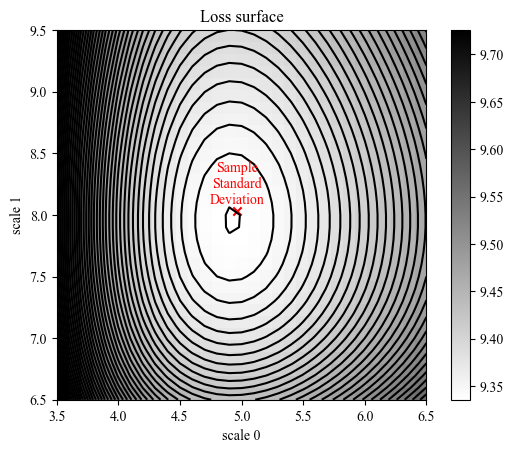

In [7]:
# Compute the loss surface
lb0, ub0, s0 = 3.5, 6.5, 0.1
lb1, ub1, s1 = 6.5, 9.5, 0.1
L = np.zeros([len(np.arange(lb0, ub0+s0 , s0)), len(np.arange(lb1, ub1+s1 , s1))])
std = np.array([0.0, 0.0])

# Repeat a few times to average out noise inherent to the pair sampling procedure
for k in range(5):
    # Iterate the scale for first and second dimension
    (Z_ab, Y_ab) = next(iterator)
    for i, scale_0 in enumerate(np.arange(lb0, ub0+s0 , s0)):
        for j, scale_1 in enumerate(np.arange(lb1, ub1+s1 , s1)):
            network.trainable_variables[1].assign([scale_0, scale_1])    
            loss = network.compute_loss(data=(Z_ab, Y_ab))
            L[i,j] += loss /5
    std += np.std(Z_ab[:,0,:], axis=0) /5

# Plot
L = L.T
plt.figure(); plt.title('Loss surface')
plt.imshow(np.flipud(L), extent=[lb0,ub0,lb1,ub1], colorizer=mpl.colorizer.Colorizer(cmap='binary'))
plt.colorbar()
plt.contour(*np.meshgrid(np.arange(lb0, ub0+s0 , s0),np.arange(lb1, ub1+s1 , s1)),L, 50,colors='k')
plt.scatter(*std, marker='x', c='r'); plt.text(*np.round(std+[0,+0.06],3), s='Sample\nStandard\nDeviation', color='r', ha='center')
plt.gca().set_aspect('equal'); plt.xlabel("scale 0"); plt.ylabel("scale 1")

plt.show()

Variable value:  [ 3. 15.]  (tweaked scaling parameters of dimension 0 and 1, respectively)


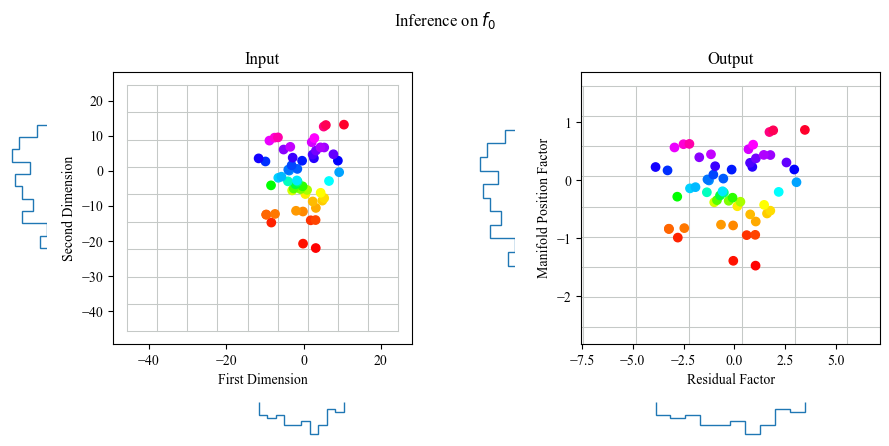

In [8]:
# Perturb scale parameters to show that they will be optimized by gradient descent later
network.trainable_variables[1].assign([3, 15.0])
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (tweaked scaling parameters of dimension 0 and 1, respectively)")

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - Train Loss: 9.3397


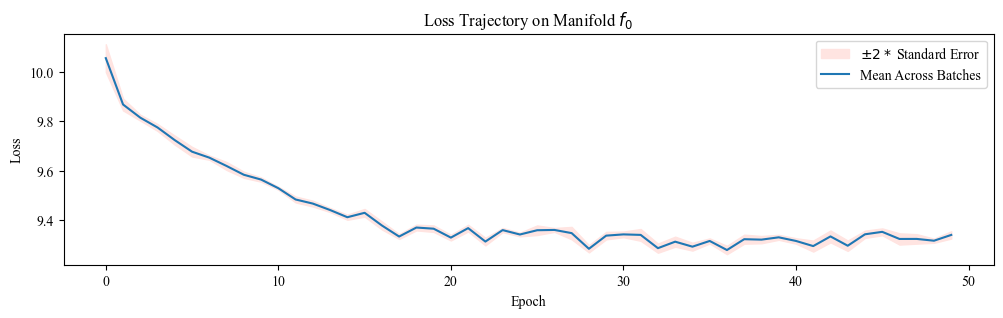

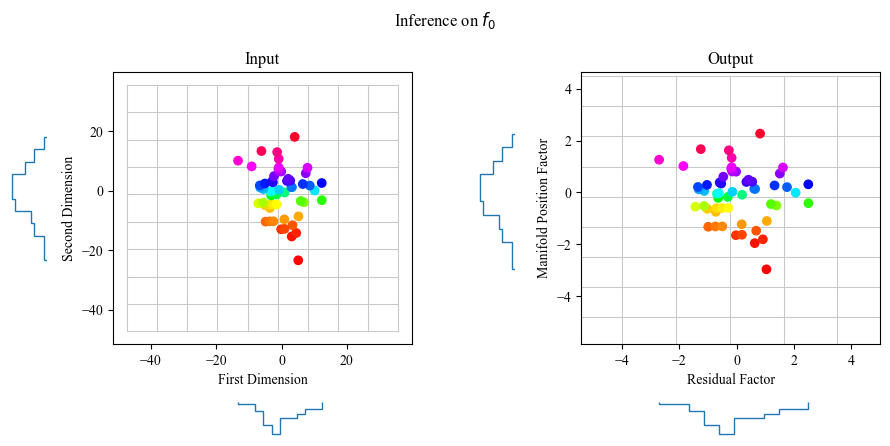

Variable path:  activation_normalization/__scale__
Variable value:  [4.90670709 7.9485945 ]  (optimized scale parameters of dimension 0 and 1, respectively)


In [9]:
# Calibrate network
learning_rate = 0.5
network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
epoch_count = 50
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

# Check scaling parameters after optimization
print("Variable path: ", network.trainable_variables[1].path)
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (optimized scale parameters of dimension 0 and 1, respectively)")

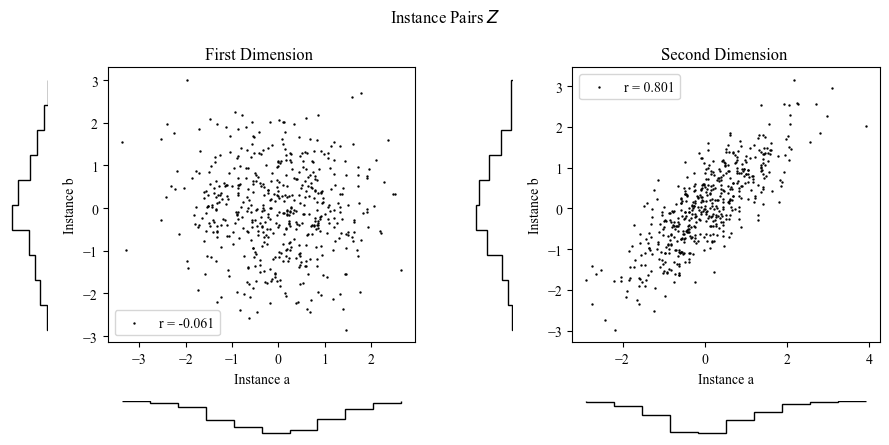

In [10]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:]
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
plot_instance_pairs_2(Z_ab=Z_tilde_ab)

(array([   8.,   67.,  276.,  730., 1128., 1175.,  832.,  374.,   98.,
          18.]),
 array([-10.94379105,  -8.85852144,  -6.77325183,  -4.68798223,
         -2.60271262,  -0.51744301,   1.5678266 ,   3.65309621,
          5.73836581,   7.82363542,   9.90890503]),
 <BarContainer object of 10 artists>)

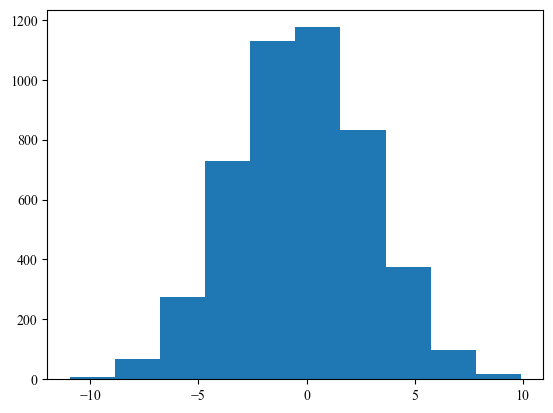

In [ ]:
'''
sigma_true = np.array([1.5, 3.4])
y_ab_fixed = np.array([0.0, 0.4])
N_pairs = 10*4096

# Generate data in the enforced (tilde) space first
ztilde_a_samples = np.random.randn(N_pairs, 2)
c_b_a = 1.0 - y_ab_fixed**2
ztilde_b_samples = (y_ab_fixed[None, :] * ztilde_a_samples + np.random.randn(N_pairs, 2) * np.sqrt(c_b_a[None, :]))

# Transform back to the original z space using true sigmas
z_a_samples = ztilde_a_samples * sigma_true[None, :]
z_b_samples = ztilde_b_samples * sigma_true[None, :]

Z_ab_new = tf.concat([z_a_samples[:,tf.newaxis,:], z_b_samples[:,tf.newaxis,:]], axis=1)
Y_ab_new = tf.repeat(y_ab_fixed[tf.newaxis,:], repeats=N_pairs, axis=0)

indices = np.logical_and(Z_ab_new[:,0,1] > -0, Z_ab_new[:,0,1] < 1)

plt.hist(Z_ab_new[indices][:,1,1]-Z_ab_new[indices][:,0,1])
'''


## Case Study 1: Rotation

### Data Synthesis

In this case study, a simple manifold is selected, namely a straight horizontal line. The model will have to learn how to rotate the point cloud $\pi / 2$ radians to align the horizontal axis of $z$ with the vertical axis of $\tilde{z}$. The data is synthesized by placing points along a straight line S on the horizontal axis of the input space. Samples are taken from S, fed through this manifold function to obtain their horizontal and vertical coordinates and Gaussian noise is added to each coordinate. In the below diagram, one can see the manifold function in gray, along with pairs of sampled instances $z_a, z_b$ in blue and orange, respectively. For each pair, the distance along the manifold (i.e. difference in their $s$ value) is shown to the right of $z_b$. It is important to realize that this similarity score only depends on the distance along the manifold (disregarding noise) and not the deviation away from it. It will later be used to incentivise the model to preserve their distances along the manifold position factor. On the contrary, the deviation from the manifold is considered unknown variation and will be captured by the model's residual factor.

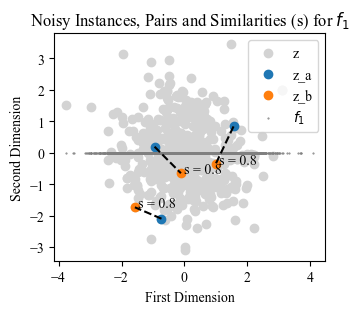

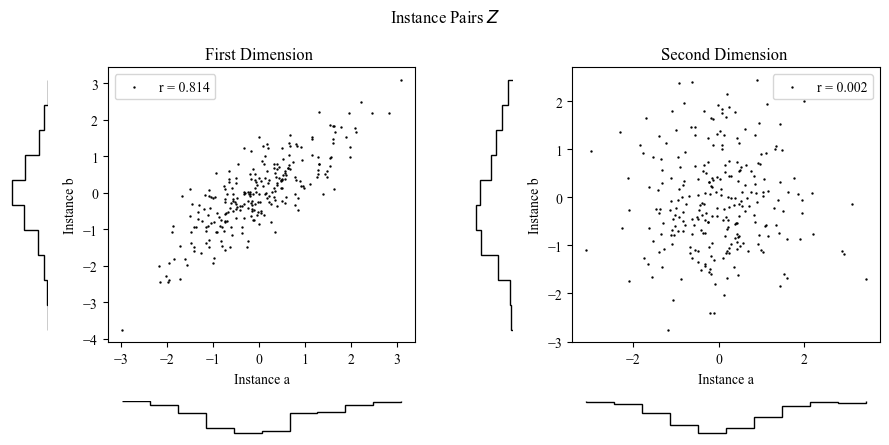

In [ ]:
manifold_name = 'f_1'

# Generate points along a line
M = 2**13; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=3) # Reproducability
S = np.random.normal(loc=0, scale=1, size=[M])

# Set up the raw manifold function
manifold_function = lambda S: (S, np.zeros(len(S)))

# Generate a dataset
noise_standard_deviation = [0.0, 1.0]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**8
target_correlations = [0.0, 0.8]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
plot_instance_pairs_2(Z_ab=Z_ab)

### Model Creation

Variable path:  reflection/reflection_normals
Variable value:  [[-0.367967   -0.92983885]]  (default initialization of dimension 0 and 1, respectively)


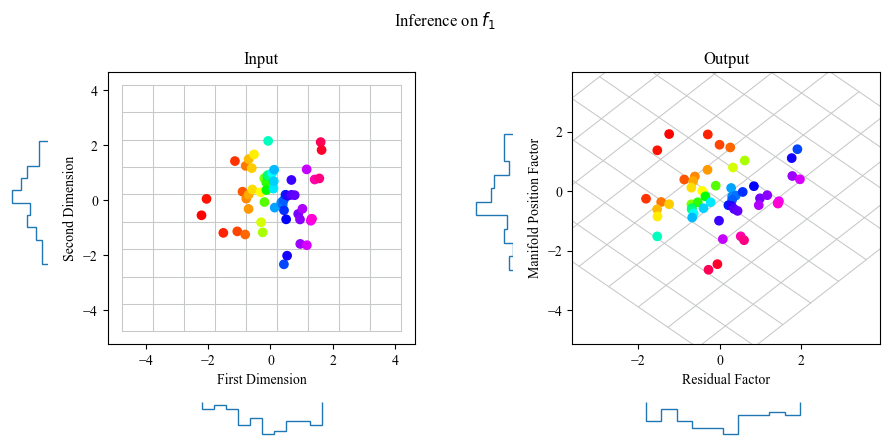

In [15]:
# Create network
def create_network():
    network = mfl.SupervisedFactorModel(layers=[mfl.Reflection(axes=[1], shape=[N], reflection_count=1)], dimensions_per_factor=[1,1], sigma=1.0)
    network.build() # Initialization of some layer parameters
    return network

reset_random_number_generators(seed=1) # Reproducability
network = create_network()

# Inspect scaling parameter
print("Variable path: ", network.trainable_variables[0].path)
print("Variable value: ", network.trainable_variables[0].value.numpy(), " (default initialization of dimension 0 and 1, respectively)")

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

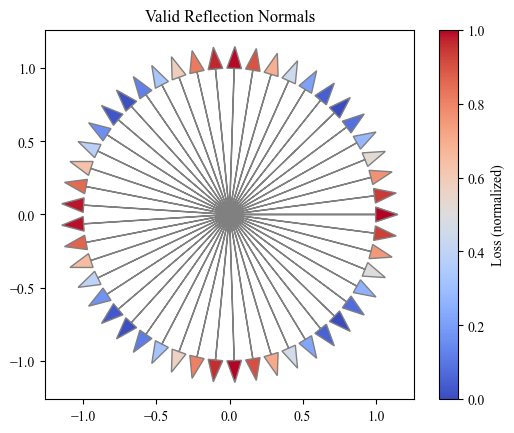

In [16]:
# Memorize current parameter values
old_parameter_values = network.trainable_variables[0].value.numpy()

# 1. Generate angles from 0 to 2*pi
theta = np.linspace(0, 2 * np.pi, 50) # 200 points for a smooth circle

# 2. Calculate x and y coordinates (radius is 1 for a unit circle)
x = np.cos(theta)
y = np.sin(theta)

L = np.zeros(len(x))
for i,x_i,y_i in zip(range(len(x)), x,y):
    network.trainable_variables[0].assign([[x_i, y_i]])
    L[i] = network.compute_loss(data=(Z_ab, Y_ab))

L = (L-np.min(L))/ np.max(L-np.min(L))

# Restore old parameter values
network.trainable_variables[0].assign(old_parameter_values)

# Plot
plt.figure(); plt.title("Valid Reflection Normals")
plt.scatter(x,y,c=L, colorizer=mpl.colorizer.Colorizer('coolwarm'), s=0.1)
for i in range(len(theta)): plt.arrow(0, 0, x[i], y[i], head_width=0.1, facecolor=mpl.colormaps['coolwarm'](L[i]), edgecolor='grey')
plt.colorbar(label='Loss (normalized)')
plt.gca().set_aspect('equal')


### Model Calibration



The model is calibrated once on all data for exploration purposes and then cross-validated on five different train and test splits to assess its robustness. As can be seen from the below diagram, the mean loss converges quickly for the chosen signle stage model. During the cross-validation procedure, the data set is split into five disjoint test sets of equal size and their corresponding composite train sets. The model is re-initialized and trained for every fold. Loss trajectories are omitted here but can be obtained by setting the corresponding input argument for the cross_validate() function. Evaluation of the cross-validation on the test data is shown further down below.


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - Train Loss: 1.9788


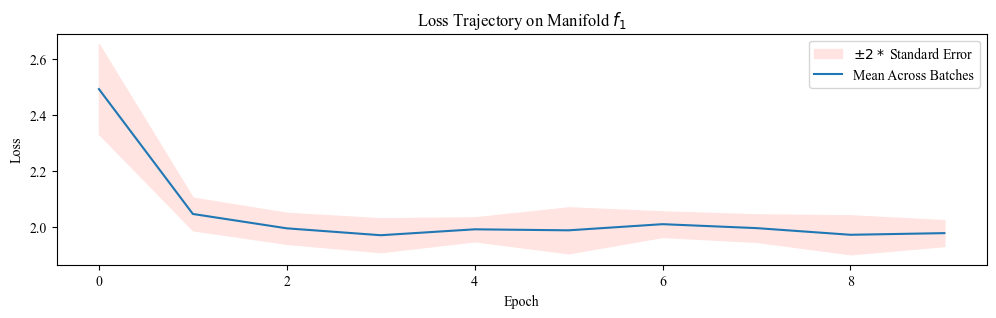

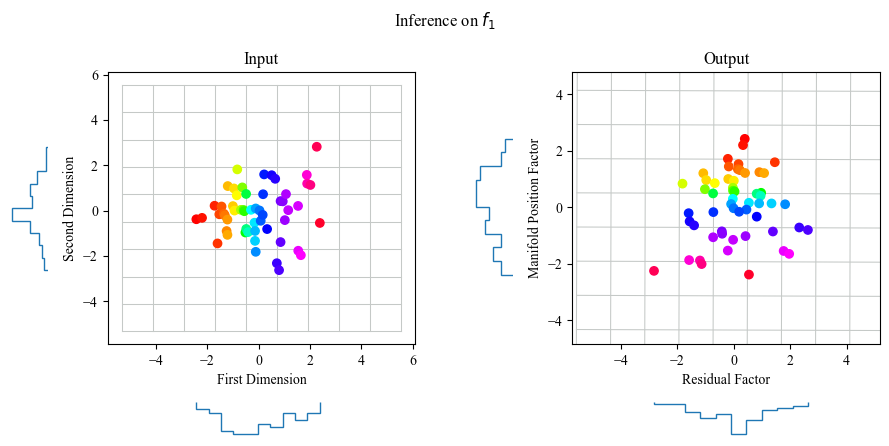

Variable path:  reflection/reflection_normals
Variable value:  [[-0.70827685 -0.70593462]]  (optimized parameters)


In [17]:
# Calibrate network
learning_rate = 0.01
network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
batch_size = M//8 # There will be 8 cross validation folds, so M//8 prevents lossing data on partial batches
epoch_count = 10
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

# Check scaling parameters after optimization
print("Variable path: ", network.trainable_variables[0].path)
print("Variable value: ", network.trainable_variables[0].value.numpy(), " (optimized parameters)")

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[batch_size], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

interactive(children=(FloatSlider(value=0.0, description='position', max=1.5, min=-1.5), FloatSlider(value=0.0…

<function __main__.plot_inverse_point(position: float, residual: float, S: numpy.ndarray, network: gyoza.modelling.flow_layers.SupervisedFactorModel, manifold_function: Callable, manifold_name: str)>

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 586ms/step - Train Loss: 1.9582
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 598ms/step - Train Loss: 1.9617
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - Train Loss: 1.9705
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - Train Loss: 1.9567
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 592ms/step - Train Loss: 1.9833
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - Train Loss: 1.9693
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 585ms/step - Train Loss: 2.0034
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 615ms/step - Train Loss: 2.0214


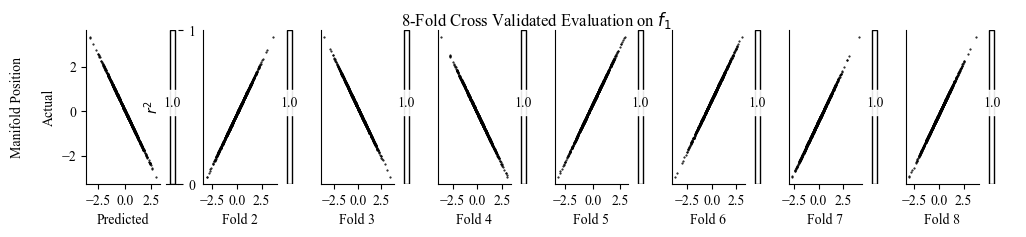

In [20]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 8 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network()
    networks[i].compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, target_correlations=target_correlations, networks=networks, batch_size=batch_size, epoch_count=epoch_count, manifold_name=manifold_name)

# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

### Evaluation

The model achieves the goal of rotating space by $\pi/2$ radians such that the output represents position along the manifold on the vertical axis and residual variation along the horizontal axis. In the below diagram one can see the input to the model on the left hand side. It shows a scatter plot of the point cloud whereby manifold position is indicated by color. On the bottom and left flanks, one can see the marginal distributions. The horizontal distribution is uniform by construction of the manifold function. The vertical factor has a normal distribition since the noise added to the data was normally distributed. On the right hand side of the diagram one can see the model output. According to the scatter plot, manifold position now varies only vertically, instead of horizontally and the marginals are both reasonably normally distributed. This indicates that the calibration objective has been reached.

The model's main effect is due to the activation normalization and reflection layers. The below diagram shows the transformation of the manifold function as it progresses through the different layers (left to right). These layers are activation normalization, reflection and coupling. The term "full coupling" means that two regular (i.e. semi-) coupling layers are combined with permutation layers to ensure all dimensions are coupled with each other. On the top of the diagram, one can see a bar chart that shows the $L_2$-norm of the difference between the layer input and output for an average sample. To better understand the nature of each layer, a first order Maclaurin series is fitted to the layer. The contribution of the affine term of that series is considered simple and reflected in the striped portion of each bar. The error of this series captures the higher order (i.e. non-linear) transformation and is shown in the dotted portion. The middle and bottom panels show the transformation on the manifold due to each of these two components. Data flows through this diagram in a zik-zak pattern, entering at the bottom of a column, up to the middle and down to the bottom of the right adjacent column.

On the one hand, one can see that the first activation normalization layer is used to reach the scale of a normal distribution. This effect acts only on the horizontal axis which has the main variation. This is a linear (location and scale) transformation and thus only the striped portion of the bar is visible. On the other hand, the reflection layer indeed aligns the horizontal axis of the input space with that of the output space. This is also a linear transformation. The coupling layer introduces a small dent in the manifold which might be there to reach the bell shape of the target normal distribution along the residual factor. Apart from that, the coupling layer and final activation normalization layer do not contribute in any noteworthy way to the model.

An important characteristic of flow models is that they are trivially invertible and this allows to convert changes in the output space to changes in the input space. The below applet shows how changing the slider along the position factor (vertical axis) of the output space results in changes along the manifold (horizontal input axis). Residual changes correspond to deviation away from the manifold. (Tip: The applet requires the model calibrated on this manifold to be in memory)

Alternatively view video at [https://drive.google.com/file/d/1sMoGQu1eXAz9NG8N_DtRZPjiCqPjI7kq/view?usp=share_link](https://drive.google.com/file/d/1sMoGQu1eXAz9NG8N_DtRZPjiCqPjI7kq/view?usp=share_link)

This problem can be solved reliably by the chosen model as can be seen from the cross validation procedure. The below diagram shows for each of five folds (train-test splits) how predicted and actual manifold position relate. Each of the five suplots contains a scatter plot that shows the linearity of the association and a bar for the proportion $r^2$ of variance in the actual position that is explained by the predicted position. Since the association is linear and $r^2$ is close to $1.0$ for each fold, one can conclude that the model is robust across different samples.

## Case Study 2: Twist

In this case study the manifold is a horizontal line with a twist in the center. It was found that this problem can be solved with a 3 stage model. The layer-wise analysis shows that the higher order contribution of the first stage and the affine contribuiton of the second stage are opposing one another. This indicates that the model might be over-parameterized. Yet, according to the cross-validation analysis it reaches linear decomposition on every fold.

### Data Synthesis

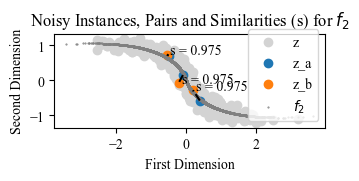

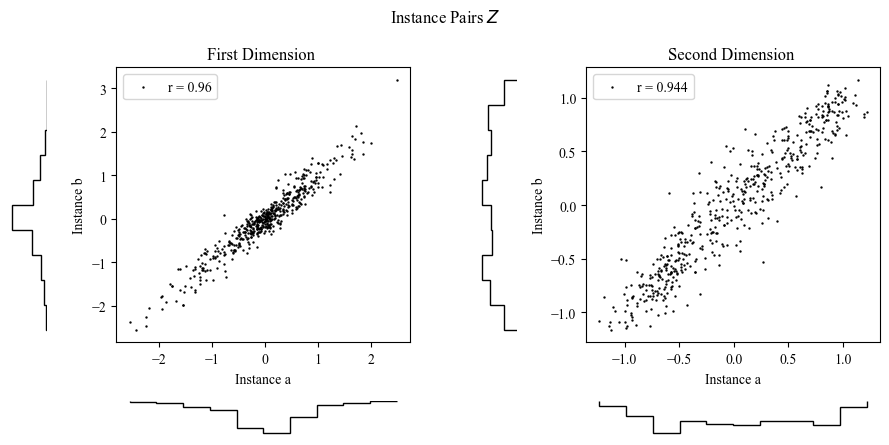

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_2'
manifold_function = lambda S: gum.rotate(xs=np.arcsinh(S), ys=np.sign(np.arcsinh(S)) * np.cosh(np.arcsinh(S)) - np.sign(S), theta=1.2*np.pi/2.0)

# Generate points along a line
M = 2**13; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=12) # Reproducability
S = np.random.normal(loc=0, scale=1, size=[M])

# Generate a dataset
noise_standard_deviation = [0.1, 0.1]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**9
target_correlations = [0.0, 0.975]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
plot_instance_pairs_2(Z_ab=Z_ab)

### Model Calibration

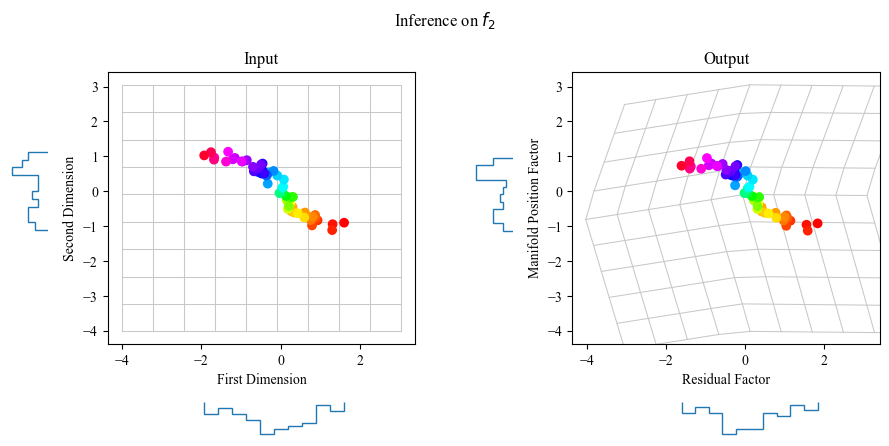

In [440]:
# Create network
def create_network(stage_count: int):

    network = mfl.SupervisedFactorModel(layers=[], dimensions_per_factor=[1,1], sigma=1.0) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    for i in range(stage_count):
        network.add(mfl.AdditiveCoupling(axes=[1], 
                                        shape=[N], 
                                        compute_coupling_parameters=msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3), 
                                        mask=gmm.CheckerBoard(axes=[1], shape=[N])))
        network.add(mfl.Heaviside(axes=[1], shape=[N]))

        network.add(mfl.AdditiveCoupling(axes=[1], 
                                        shape=[N], 
                                        compute_coupling_parameters=msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3), 
                                        mask=gmm.CheckerBoard(axes=[1], shape=[N])))
        network.add(mfl.Heaviside(axes=[1], shape=[N]))

    return network

reset_random_number_generators(seed=2) # Reproducability
stage_count = 2
network = create_network(stage_count=stage_count)

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)


75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 817ms/step - Train Loss: 0.3362


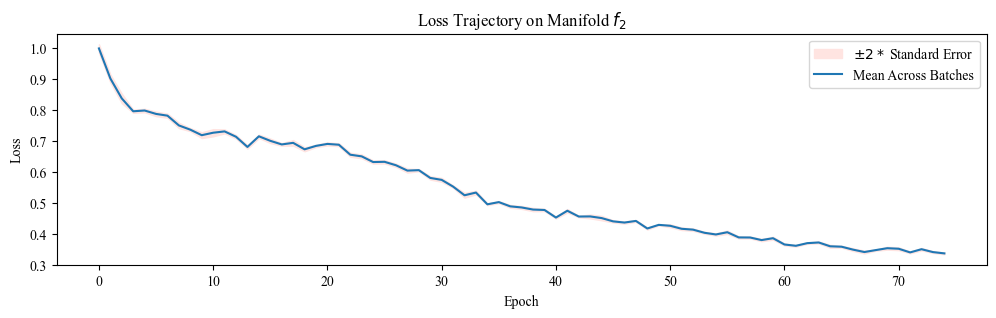

In [442]:
# Calibrate network
learning_rate = 0.01
network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
batch_size = M//8
epoch_count = 75
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [453]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 8 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(stage_count = stage_count)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, target_correlations=target_correlations, networks=networks, batch_size=batch_size, epoch_count=epoch_count, manifold_name=manifold_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - Train Loss: 0.2228
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - Train Loss: 0.2252
75/75 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - Train Loss: 0.2189
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - Train Loss: 0.2218
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - Train Loss: 0.2206
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - Train Loss: 0.2206
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - Train Loss: 0.2197
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - Train Loss: 0.2216


### Evaluation

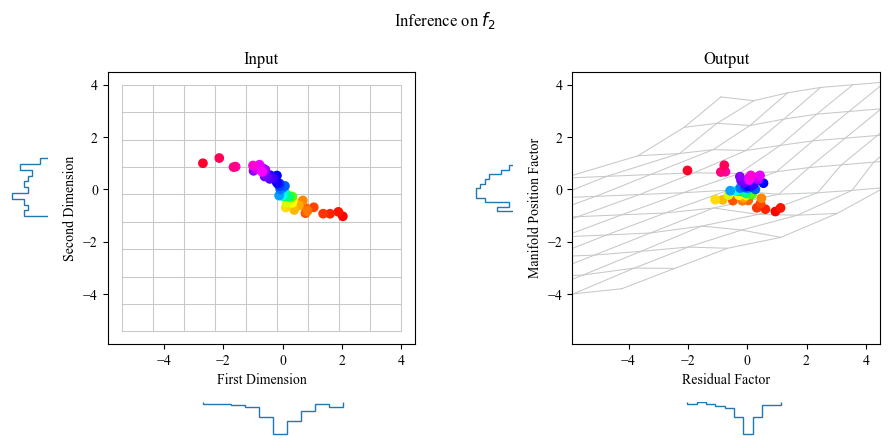

In [452]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [449]:
# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[128], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

interactive(children=(FloatSlider(value=0.0, description='position', max=1.5, min=-1.5), FloatSlider(value=0.0…

<function __main__.plot_inverse_point(position: float, residual: float, S: numpy.ndarray, network: gyoza.modelling.flow_layers.SupervisedFactorModel, manifold_function: Callable, manifold_name: str)>

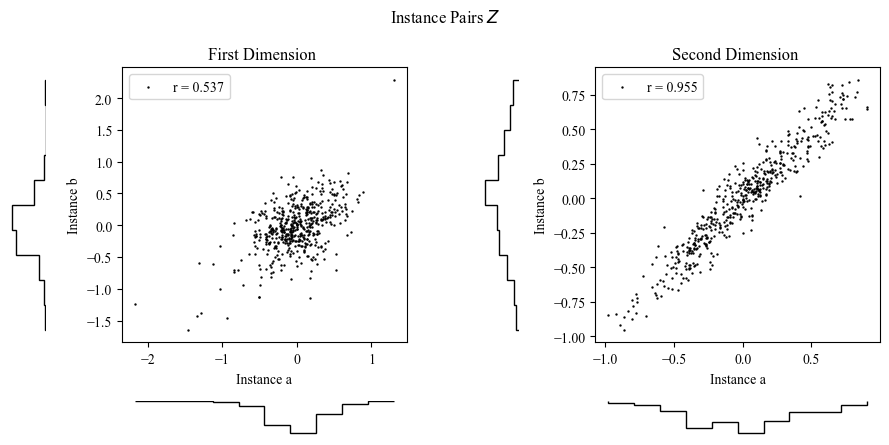

In [450]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:]
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
plot_instance_pairs_2(Z_ab=Z_tilde_ab)

Alternatively view video at [https://drive.google.com/file/d/1RQ2D4RyfPStgaa7o1MVWq1rQ5ycy4p65/view?usp=share_link](https://drive.google.com/file/d/1RQ2D4RyfPStgaa7o1MVWq1rQ5ycy4p65/view?usp=share_link)

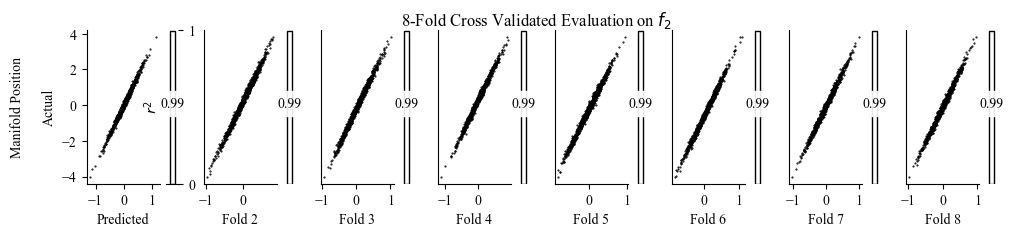

In [454]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Case Study 3: Discontinuity


### Model
The here chosen model uses several flow layers including reflection, permutation and coupling layers. The model starts with an activation normalization layer. For stability of processing, this layer is initialized such that its output has zero mean and unit standard deviation. During calibration, its location and scale parameters are adjusted to provide more optimal output. Processing continues through a sequence of stages (see below diagram), each of which has the same layers. The number of stages is a hyper-parameter that can be chosen small for simple case studies (e.g. the first study) and large for difficult case studies (e.g. studies 4 and 5).

A stage starts off with a reflection layer that produces a rotation of the input by means of two Householder reflections. This can help to align principal axes of variation in $z$ with the factor axes in $\tilde{z}$. Thereafter an additive coupling layer is used. This layer selects half of the dimensions of its input, transforms them in some non-linear way (here with a regular artificial neural network) and adds them to the other half of dimensions. This introduces non-linear transformations that allow to contract and expand space in different regions. It is followed by a permutation layer (here a Heaviside permutation) that swops dimensions. In a consecutive coupling layer the other half of dimensions is then coupled with the first. After another Heaviside permutation, all dimensions are coupled and placed at their original indices. A stage finishes with another activation normalization layer to ensure stability of the processing pipeline. For each layer, a detailed description can be found in the documentation of the flow network package [gyoza](https://gyoza.readthedocs.io/en/latest/).

![Image](https:/ /github.com/TimHenry1995/gyoza/blob/develop/docs/images/Manifold%20Tutorial%20Model.png?raw=true)

This case study examines to what extend the model can solve the manifold position problem in presence of a discontinuity. A manifold function was set up that splits $S$ in the middle and arranges the two halves as horizontal, partially overlapping straight lines. It was found that a 3 stage model can be calibrated reliably to provide the desired output distribution. When inspecting the layerwise contribution, one can see that the position and residual factors are disentangled at the end of the second stage. Although the third stage has proportionally the largest mean change from input to output, its main contribution is is scaling the factors to size. The cross-validation shows that the model reliably learns to disentangle the factors across partitions of the data.

### Data Synthesis

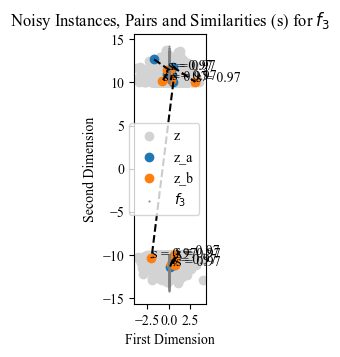

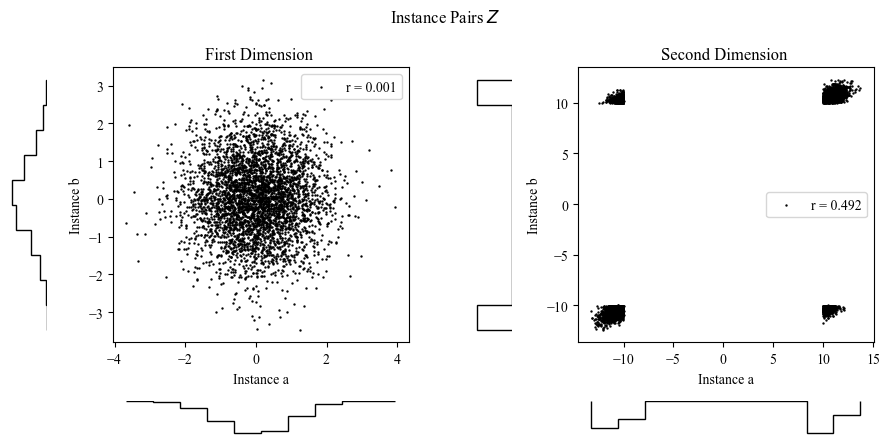

In [ ]:
manifold_name = 'f_3'

# Generate points along a line
M = 2**16; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=1) # Reproducability
S = np.random.normal(loc=0, scale=1, size=[M])

# Set up the raw manifold function
def manifold_function(S):
    Z_1 = np.copy(S)
    Z_1[np.where(0.0 <= S)] += 10
    Z_1[np.where(0.0 >= S)] -= 10
    Z_2 = np.zeros_like(Z_1)
    #Z_2[np.where(0.0 <= S)] += s_max/2
    #Z_2[np.where(S < 0.0)] -= s_max/2
    
    return gum.rotate(xs=Z_1, ys=Z_2, theta=np.pi/2)

# Generate a dataset
reset_random_number_generators(seed=1) # Reproducability
noise_standard_deviation = [1.0, 0.0]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
batch_size = M//16
target_correlations = [0.0, 0.97]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name, pair_count=10)
plot_instance_pairs_2(Z_ab=Z_ab)


### Model Calibration

In [93]:
# Create network
'''
def create_network(stage_count: int, random_seed: int = 0, sigma: float = 0.95) -> mfl.SupervisedFactorModel:
    """This function creates a supervised factor network that has starts with an activation normalization layer and then has ``stage_count`` many
    consecutive processing stages. Each stage consists of a reflection layer, followed by an full coupling layer (two additive coupling layers, each
    followed by a Heaviside permutation, one with nagative) and an activation normalization layer. During inference, the network takes input :math:`Z`
    and outputs :math:'\tilde{Z}' which each have shape [:math:`M`, :math:`N`], where :math:`M` is the instance count and :math:`N=2` is the
    dimensionality.

    :param stage_count: The number of processing stages that the ``network`` shall use.
    :type stage_count: int
    :param random_seed: The seed used to reset the random number generators.
    :type random_seed: int, optional, defaults to 0
    :param sigma: The association strength of maximally similar data points. It should be in the range (0,1].
    :type sigma: float, default = 1
    :return: network (:class:`SupervisedFactorModel`) - The network.
    """
    reset_random_number_generators(seed=random_seed) # Reproducability
    
    # Set up the coupling functions and masks for the coupling layers
    layers = [None] * (6*stage_count+1)
    layers[0] = mfl.ActivationNormalization(axes=[1], shape=[N])
    for i in range(stage_count):
        layers[6*i+1] = mfl.Reflection(axes=[1], shape=[N], reflection_count=1)

        compute_coupling_parameters_1 = msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3)
        mask_1 = gmm.CheckerBoard(axes=[1], shape=[N])

        layers[6*i+2] = mfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1)
        layers[6*i+3] = mfl.Heaviside(axes=[1], shape=[N])

        compute_coupling_parameters_2 = msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3)
        mask_2 = gmm.CheckerBoard(axes=[1], shape=[N])

        layers[6*i+4] = mfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2)
        layers[6*i+5] = mfl.Heaviside(axes=[1], shape=[N])

        layers[6*i+6] = mfl.ActivationNormalization(axes=[1], shape=[N])

    # Construct the network
    network = mfl.SupervisedFactorModel(layers, dimensions_per_factor=[1,1], sigma=sigma) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    
    # Outputs
    return network
''' 
def create_network(stage_count: int):

    network = mfl.SupervisedFactorModel(layers=[], dimensions_per_factor=[1,1], sigma=1.0) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    #network.add(mfl.ActivationNormalization(shape=[N], axes=[1]))
    for i in range(stage_count):
        network.add(mfl.AdditiveCoupling(axes=[1], 
                                        shape=[N], 
                                        compute_coupling_parameters=msl.BasicFullyConnectedNet(latent_dimension_count=2*N, output_dimension_count=N, depth=3), 
                                        mask=gmm.CheckerBoard(axes=[1], shape=[N])))
        network.add(mfl.Heaviside(axes=[1], shape=[N]))

        network.add(mfl.AdditiveCoupling(axes=[1], 
                                        shape=[N], 
                                        compute_coupling_parameters=msl.BasicFullyConnectedNet(latent_dimension_count=2*N, output_dimension_count=N, depth=3), 
                                        mask=gmm.CheckerBoard(axes=[1], shape=[N])))
        network.add(mfl.Heaviside(axes=[1], shape=[N]))
    
    return network

reset_random_number_generators(seed=12) # Reproducability

network = create_network(stage_count=2)

In [7]:
network(Z)
network.trainable_variables

[<Variable path=activation_normalization/__location__, shape=(2,), dtype=float64, value=[0.00566355 0.00808946]>,
 <Variable path=activation_normalization/__scale__, shape=(2,), dtype=float64, value=[0.99530101 2.27006958]>,
 <Variable path=supervised_factor_model/additive_coupling/basic_fully_connected_net/sequential/dense/kernel, shape=(2, 4), dtype=float64, value=[[-0.72511899  0.70632023 -0.57538312 -0.33291928]
  [-0.3565681   0.83722137 -0.64154654 -0.87106216]]>,
 <Variable path=supervised_factor_model/additive_coupling/basic_fully_connected_net/sequential/dense/bias, shape=(4,), dtype=float64, value=[0. 0. 0. 0.]>,
 <Variable path=supervised_factor_model/additive_coupling/basic_fully_connected_net/sequential/dense_1/kernel, shape=(4, 4), dtype=float64, value=[[ 0.4025832  -0.65033972 -0.25736219  0.46961433]
  [ 0.53580433 -0.39004526 -0.15936006  0.18889783]
  [ 0.00507062  0.63543601  0.18190128  0.60251761]
  [ 0.09915758  0.68618227  0.55957073 -0.2070418 ]]>,
 <Variable pa

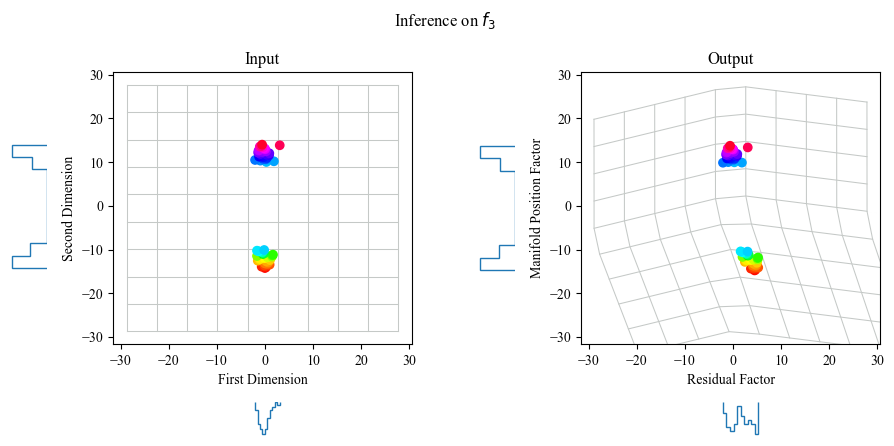

In [94]:
# Plot input and output

plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

5/5 ━━━━━━━━━━━━━━━━━━━━ 318s 67s/step - Train Loss: 26.7242 


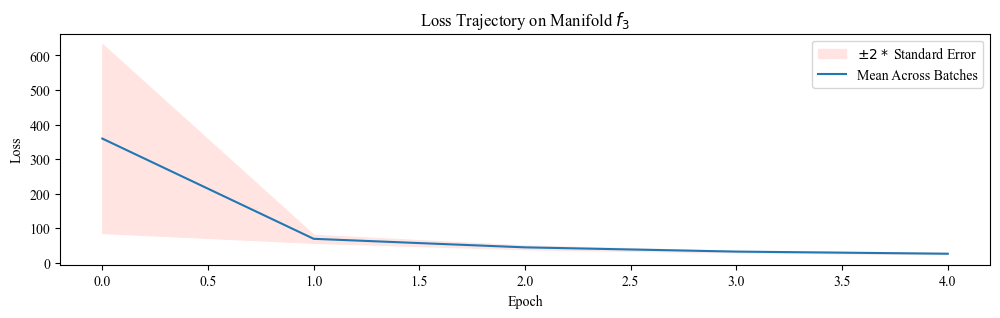

In [97]:
# Calibrate network
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05))
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=5, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=75, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

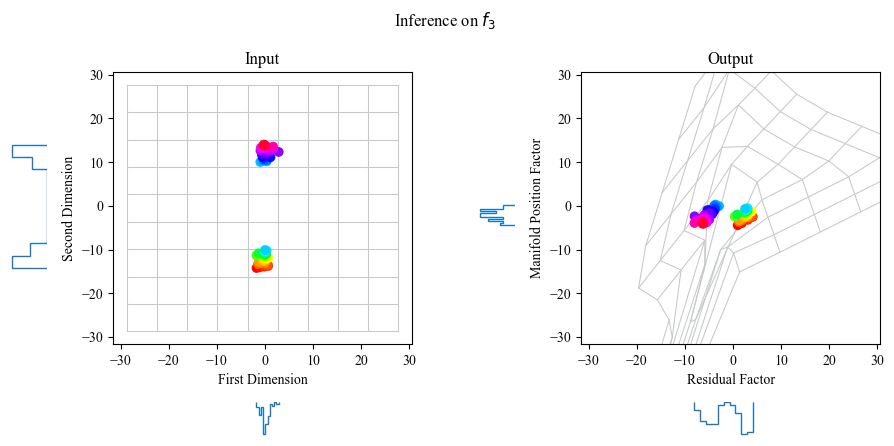

In [98]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-2.5,2.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[batch_size], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

interactive(children=(FloatSlider(value=0.0, description='position', max=2.5, min=-2.5), FloatSlider(value=0.0…

<function __main__.plot_inverse_point(position: float, residual: float, S: numpy.ndarray, network: gyoza.modelling.flow_layers.SupervisedFactorModel, manifold_function: Callable, manifold_name: str)>

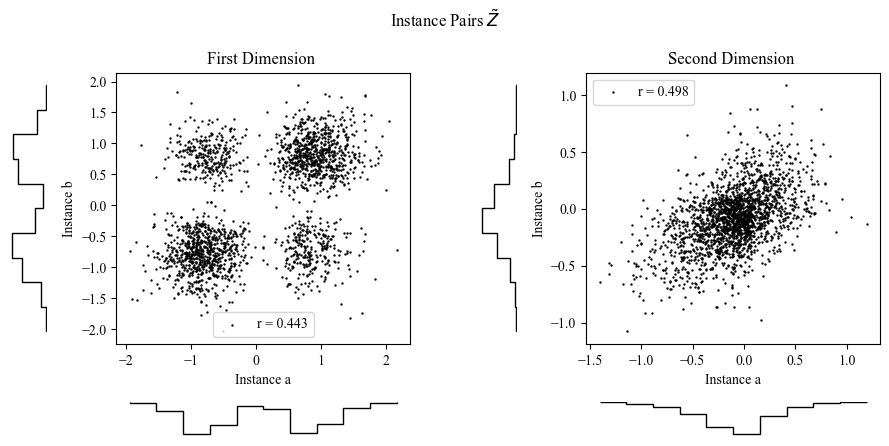

In [351]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:]
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
plot_instance_pairs_2(Z_ab=Z_tilde_ab, title_suffix=r"$\tilde{Z}$")

Alternatively view video at [https://drive.google.com/file/d/1hHSfL5-bJqtgnsAMq_9vfiVhyZsih6-3/view?usp=share_link](https://drive.google.com/file/d/1hHSfL5-bJqtgnsAMq_9vfiVhyZsih6-3/view?usp=share_link)

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Case Study 4: Spiral

In this case study the advanced case of a spiral manifold is solved by the flow model under consideration. Similar to the other case studies, this one can be solved by a three stage model. As can be seen from the stage-wise decomposition, the majority of the disentanglement is completed at the end of the second stage and therafter the point-cloud is rescaled. The cross-validation analysis shows that the model reliably solves the task across the five partitions of the data.

### Data Synthesis

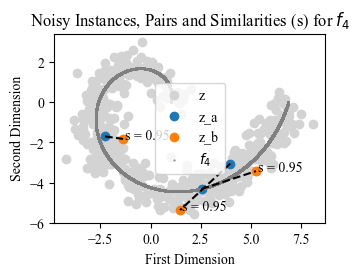

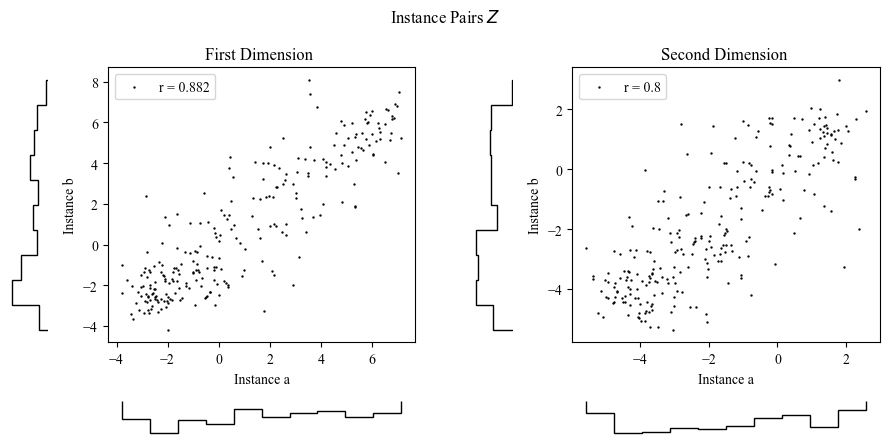

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_4'
manifold_function = lambda S: gum.logarithmic_spiral(xs=np.log((S+s_max)/(1*np.sqrt(1+beta**2)/beta)+1)/beta, alpha=1, beta=beta) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t

# Generate a dataset
golden_ratio = (1 + 5 ** 0.5) / 2
beta = np.log(golden_ratio)/(np.pi/2) # https://en.wikipedia.org/wiki/Golden_spiral see section on mathematics
s_max = (1*np.sqrt(1+beta**2)/beta)*(np.exp(beta*2*np.pi)-1)/2 # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t the arc length of the golden spiral for one full rotation
S = np.linspace(-s_max,s_max,M, dtype=tf.keras.backend.floatx()) # These points are the steps along any manifold

reset_random_number_generators(seed=653) # Reproducability
noise_standard_deviation = [0.5, 0.5]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

batch_size = 2**8
target_correlations = [0.0, 0.95]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
plot_instance_pairs_2(Z_ab=Z_ab)

In [12]:

def create_network(stage_count: int, random_seed: int = 0, sigma: float = 0.95) -> mfl.SupervisedFactorModel:
    """This function creates a supervised factor network that has starts with an activation normalization layer and then has ``stage_count`` many
    consecutive processing stages. Each stage consists of a reflection layer, followed by an full coupling layer (two additive coupling layers, each
    followed by a Heaviside permutation, one with nagative) and an activation normalization layer. During inference, the network takes input :math:`Z`
    and outputs :math:'\tilde{Z}' which each have shape [:math:`M`, :math:`N`], where :math:`M` is the instance count and :math:`N=2` is the
    dimensionality.

    :param stage_count: The number of processing stages that the ``network`` shall use.
    :type stage_count: int
    :param random_seed: The seed used to reset the random number generators.
    :type random_seed: int, optional, defaults to 0
    :param sigma: The association strength of maximally similar data points. It should be in the range (0,1].
    :type sigma: float, default = 1
    :return: network (:class:`SupervisedFactorModel`) - The network.
    """
    reset_random_number_generators(seed=random_seed) # Reproducability
    
    # Set up the coupling functions and masks for the coupling layers
    layers = [None] * (6*stage_count+1)
    layers[0] = mfl.ActivationNormalization(axes=[1], shape=[N])
    for i in range(stage_count):
        layers[6*i+1] = mfl.Reflection(axes=[1], shape=[N], reflection_count=1)

        compute_coupling_parameters_1 = msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3)
        mask_1 = gmm.CheckerBoard(axes=[1], shape=[N])

        layers[6*i+2] = mfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1)
        layers[6*i+3] = mfl.Heaviside(axes=[1], shape=[N])

        compute_coupling_parameters_2 = msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3)
        mask_2 = gmm.CheckerBoard(axes=[1], shape=[N])

        layers[6*i+4] = mfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2)
        layers[6*i+5] = mfl.Heaviside(axes=[1], shape=[N])

        layers[6*i+6] = mfl.ActivationNormalization(axes=[1], shape=[N])

    # Construct the network
    network = mfl.SupervisedFactorModel(layers, dimensions_per_factor=[1,1], sigma=sigma) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    
    # Outputs
    return network
 

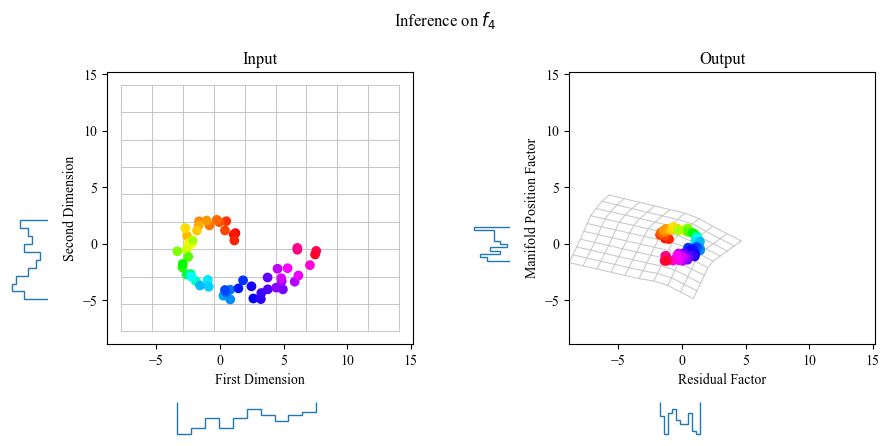

In [75]:
# Create network
reset_random_number_generators(seed=2) # Reproducability
network = create_network(stage_count=3)

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

### Model Calibration

5/5 ━━━━━━━━━━━━━━━━━━━━ 104s 21s/step - Train Loss: 4.0495


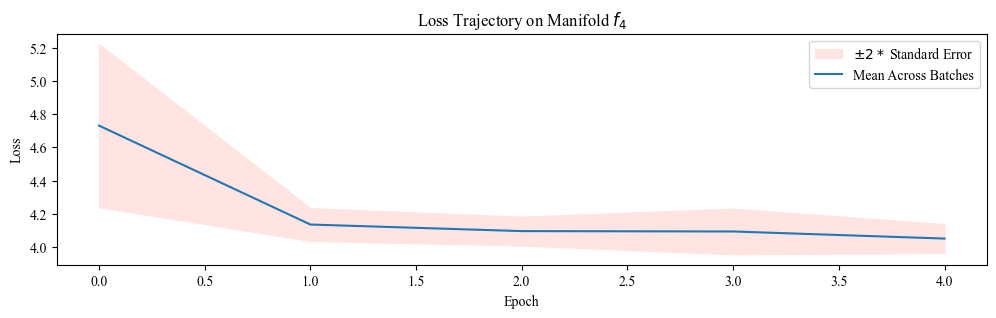

In [76]:

# Calibrate network

network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
batch_size = 1024
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=5, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=346) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=800, epoch_count=200, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

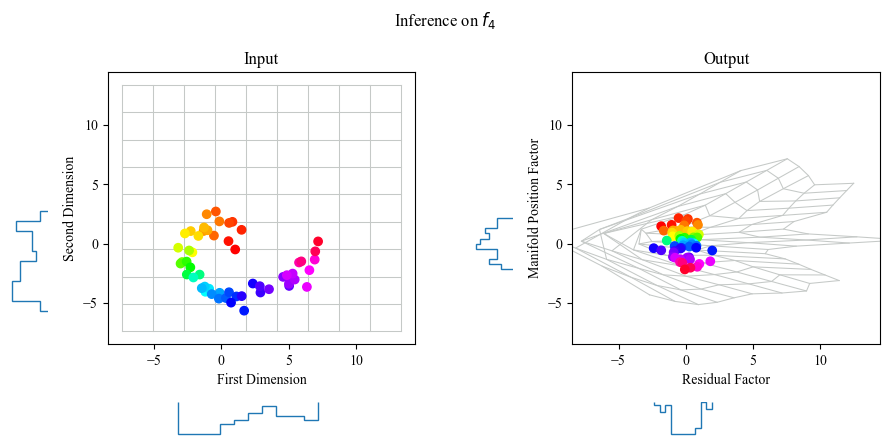

In [77]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [78]:
# Plot interactive tool
interact(plot_inverse_point, position=(-2.0,2.0,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[128], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name));

interactive(children=(FloatSlider(value=0.0, description='position', max=2.0, min=-2.0), FloatSlider(value=0.0…

Alternatively view video at [https://drive.google.com/file/d/136PsRhKtIoHqKZPFY9HS_iVRkGe-GB29/view?usp=share_link](https://drive.google.com/file/d/136PsRhKtIoHqKZPFY9HS_iVRkGe-GB29/view?usp=share_link)

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Case Study 5: Circle

In this case study the model is calibrated to straighten a circular manifold. This task is difficult because at the junction point of the circle (point (1,0)) there exist adjacent points that are supervised to be maximally distant. As can be seen from the layer-wise analysis, the circle is split already at the non-linear component of the first stage. Since the coupling layer is the only one capable of non-linear transformations it shows the importance of that layer. The position factor is disentangled from the residual factor by the end of the second layer and the third layer ensures proper scaling. The loss trajectory of this model remains spiky throughout the calibration. Furthermore, the cross-validation analysis shows that not all versions of the model manage to create a linear relationship between predicted and actual position. These observations hint at the complexity of this task.

### Data Synthesis

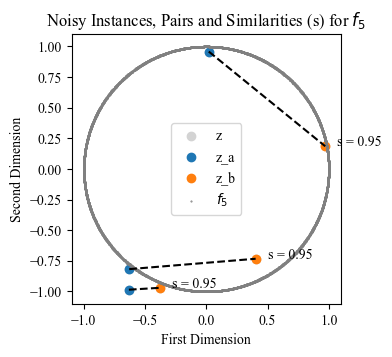

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_5'
manifold_function = lambda S: (np.cos(S), np.sin(S))#((2*s_max/(2*np.pi))*np.cos((S+s_max)*(2*np.pi)/(2*s_max)), (2*s_max/(2*np.pi))* np.sin((S+s_max)*(2*np.pi)/(2*s_max)))

M = 2**13; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=3) # Reproducability
S = np.random.uniform(low=0, high=2*np.pi, size=[M])#np.random.normal(loc=0, scale=1, size=[M])

# Generate a dataset
reset_random_number_generators(seed=123) # Reproducability
noise_standard_deviation = [0.1, 0.1]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
batch_size = M//8
target_correlations = [0.0, 0.95]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

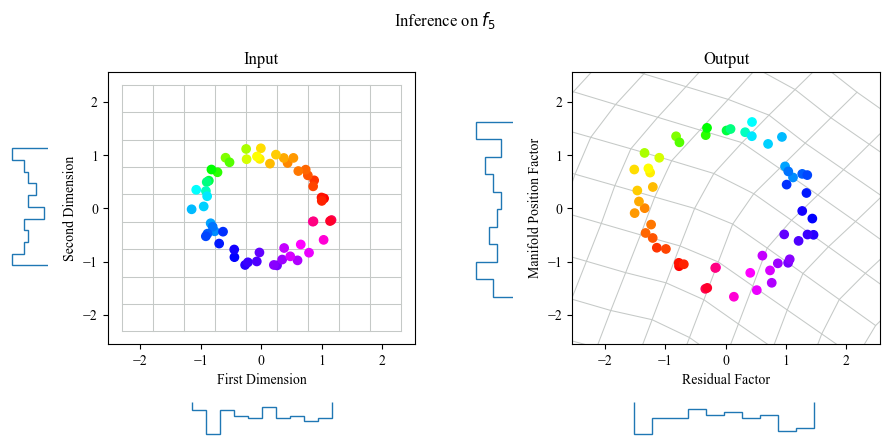

In [99]:
# Create network
reset_random_number_generators(seed=52) # Reproducability
network = create_network(stage_count=3)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);


100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - Train Loss: -0.5656


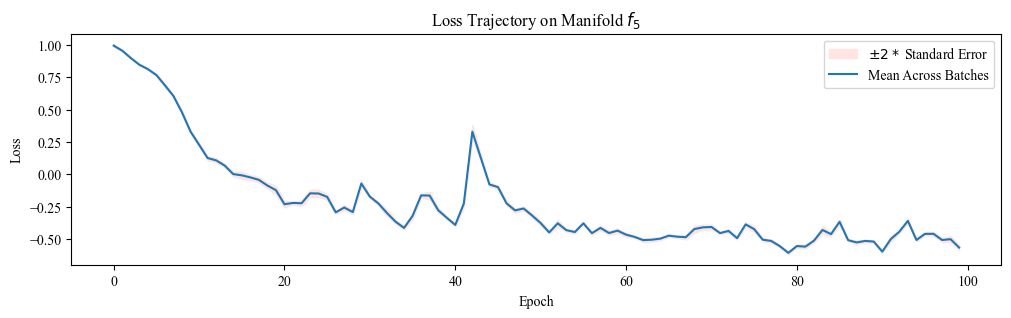

In [100]:
# Calibrate network
batch_size = M//8
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=100, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

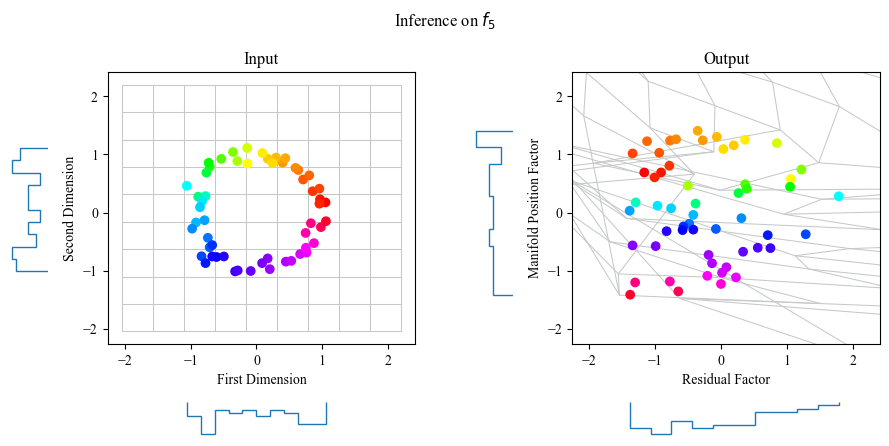

In [101]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=958) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=800, epoch_count=1000, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [102]:
# Plot interactive tool
interact(plot_inverse_point, position=(-1.2,1.2,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[batch_size], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name));

interactive(children=(FloatSlider(value=-0.09999999999999987, description='position', max=1.2, min=-1.2), Floa…

Alternatively view video at [https://drive.google.com/file/d/1_el2ls7fAhHY5PrALDi9jSPkoVyWAOd3/view?usp=share_link](https://drive.google.com/file/d/1_el2ls7fAhHY5PrALDi9jSPkoVyWAOd3/view?usp=share_link)

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Case Study 6: Dipole

In this case study the manifold takes the shape of two poles, i.e. dots which gives rise to a problem similar to classification. Points on the same pole are all maximally close while points on separate poles are maximally distant. As can be seen from the scatterplots, the model places all points from the right pole into the lower halfplane and all points from the left pole into the upper halfplane. The separation thus worked. When inspecting the layerwise contributions one can see that the linear and non-linear parts counteract each other to some extent. It is possible that a model with fewer layers would already suffice to solve the task. As she cross-validation results show, different initializations of the model lead to a working separation, thereby underlining the reliability of the model.

### Data Synthesis

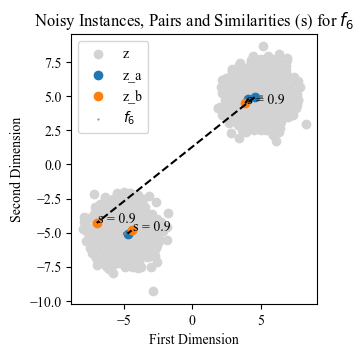

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_6'
manifold_function = lambda S: (5*(2*(0 < S) - 1), 5*(2*(0 < S) - 1))


# Generate a dataset
reset_random_number_generators(seed=856) # Reproducability
M = 2**14
noise_standard_deviation = [1.0, 1.0]
target_correlations = [0, 0.9]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
batch_size = M//8
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

10/10 ━━━━━━━━━━━━━━━━━━━━ 274s 27s/step - Train Loss: 4.7646


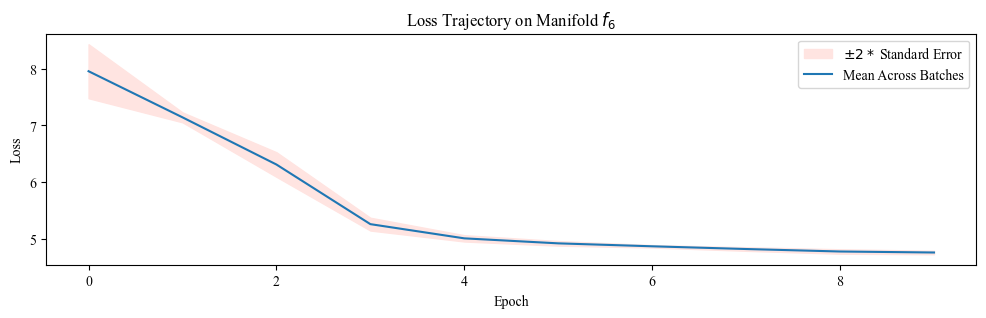

In [69]:
# Create network
reset_random_number_generators(seed=286) # Reproducability
network = create_network(stage_count=3, sigma = 1.0)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Calibrate network
batch_size = 1024
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=10, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

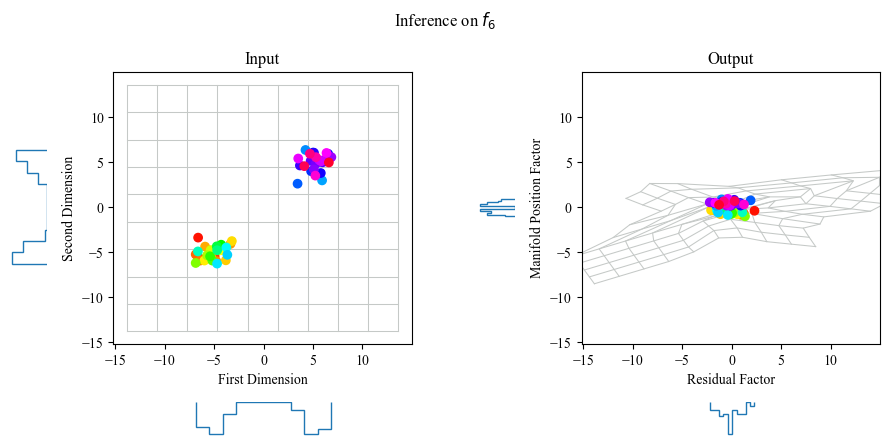

In [74]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

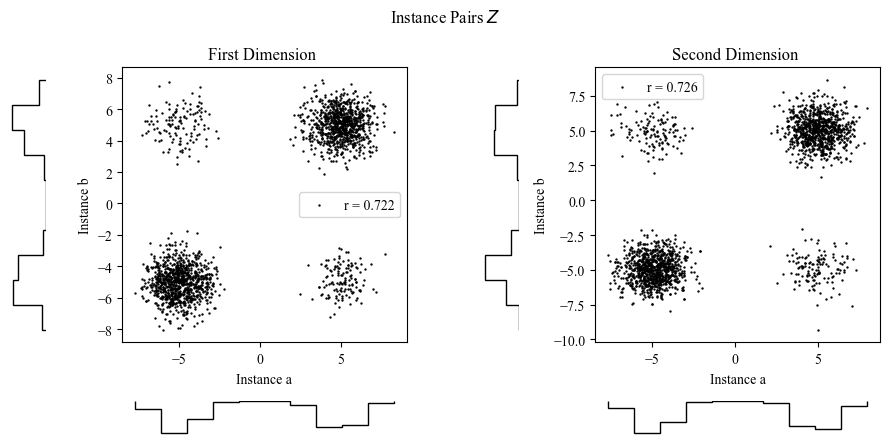

In [75]:
plot_instance_pairs_2(Z_ab=Z_ab)

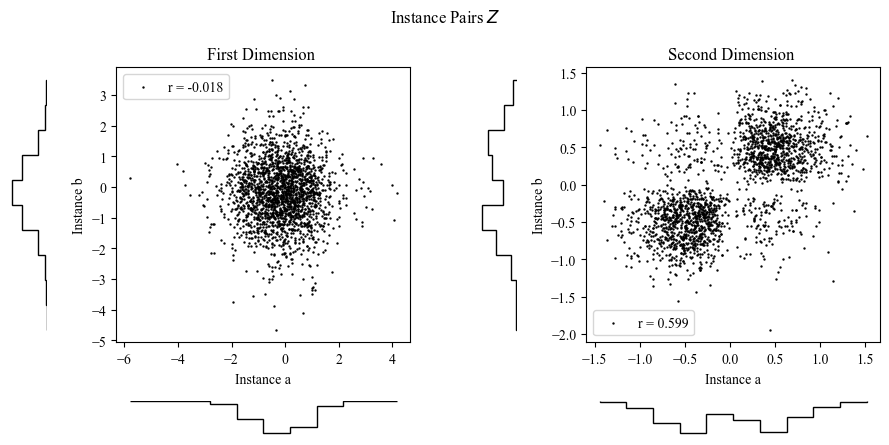

In [76]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:]
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
plot_instance_pairs_2(Z_ab=Z_tilde_ab)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=958) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3, sigma = 0.8)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=100, similarity_function=similarity_function_6, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-2,2,0.1), S=fixed(S_sample), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name));

Alternatively view video at [https://drive.google.com/file/d/1KEjKZJvX6ULqrRHyh8WR82e2NzmdwB4M/view?usp=share_link](https://drive.google.com/file/d/1KEjKZJvX6ULqrRHyh8WR82e2NzmdwB4M/view?usp=share_link)

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Case Study 7: Quartet

This case study separates its manifold into four poles and thus constitutes an advancement of the dipole case study. It is more complex because the model has more freedom is arranging four poles along its position factor than two poles. The calibration trajectory converges, indicating the stability of the model. One can see in the scatter plots that the model manages to enumerate the four poles along the position axis. The layer-wise analysis shows that all 3 stages use linear and non-linear operations and the later stages still have a large contribution to the output. As can be seen from the cross-validation plots, not all model initializations create a clustered assocation of model input and output. This confirms the increased complexity compared to the dipole case.  

### Data Synthesis

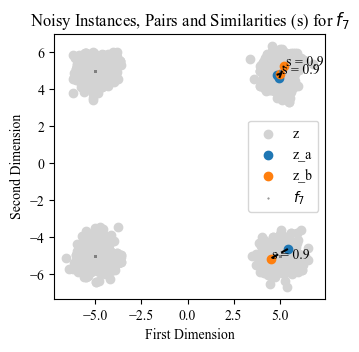

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_7'
def manifold_function(S):
    s_max = np.max(S)
    centroids = 5*np.array([[-1.0,1],[-1,-1],[1,1],[1,-1]])
    tmp = centroids[0] * (S[:,np.newaxis] < -s_max/2)
    tmp = tmp + centroids[1] * np.logical_and(-s_max/2 <= S, S < 0)[:,np.newaxis]
    tmp = tmp + centroids[2] * np.logical_and(0 <= S, S < s_max/2)[:,np.newaxis]
    tmp = tmp + centroids[3] * (s_max/2 <= S[:,np.newaxis])
    return (tmp[:,0], tmp[:,1])

# Generate a dataset
reset_random_number_generators(seed=395) # Reproducability
noise_standard_deviation = [0.5, 0.5]
M = 2**13
S = np.random.uniform(low=-1, high=1, size=[M])
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
batch_size = M//8
target_correlations = [0.0, 0.9]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

100/100 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - Train Loss: 3.7290


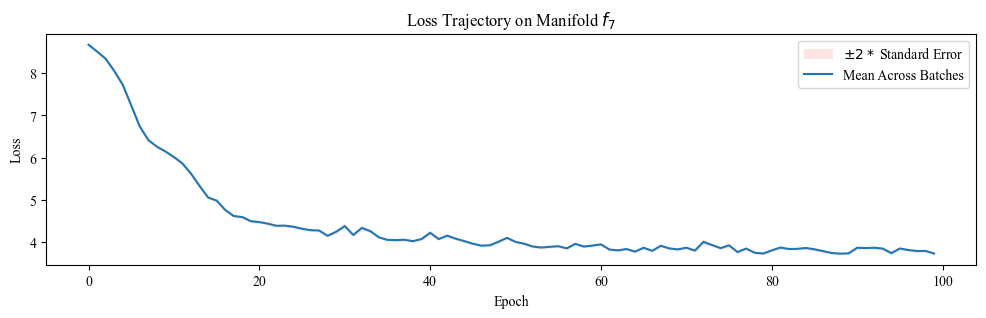

In [83]:
# Create network
reset_random_number_generators(seed=294) # Reproducability
network = create_network(stage_count=3, sigma =1.0)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Calibrate network
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=100, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

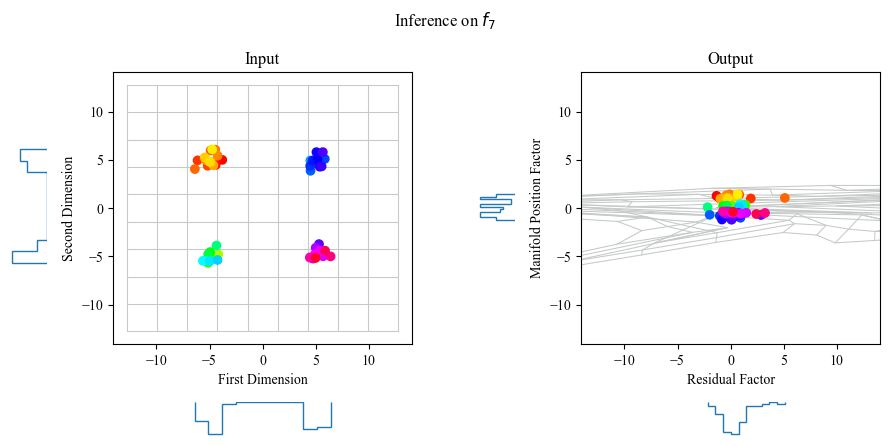

In [84]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=958) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3, sigma=0.8)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=200, similarity_function=similarity_function_7, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-2,2,0.1), residual=(-2,2,0.1), S=fixed(S_sample), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name));

Alternatively view video at [https://drive.google.com/file/d/1Iqd7jj6606GIVTAxEVRoJLQxlK3laaMh/view?usp=share_link](https://drive.google.com/file/d/1Iqd7jj6606GIVTAxEVRoJLQxlK3laaMh/view?usp=share_link)

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Case Study 8: Flip Flop

In this case study the manifold takes the shape of two intermingling flaps. The position along the manifold is either on the left flap or on the right flap (thus no distinction for position along a flap). It therefore combines the discontinuity, curvature and category properties of earlier case studies. The model does converge throughout calibration. As can be seen from the scatterplots, the disentanglement aligns the left flap with the top halfplane and the right flap with the bottom half plane. Although not explicitly supervised to do so, it preserves proximities of data points. This is likely due to the fact that the data points were arranged along the flap in the input space and permuting them would require a more complicated mapping than necessary. The first three stages of the model are mostly responsible for the non-linear transformations while the last two stages are responsible for rotation and scaling, indicating that a smaller model might also work. Lastly, the cross-validation results show that different initializations of the model all lead to a reliable separation of the flaps.

### Data Synthesis

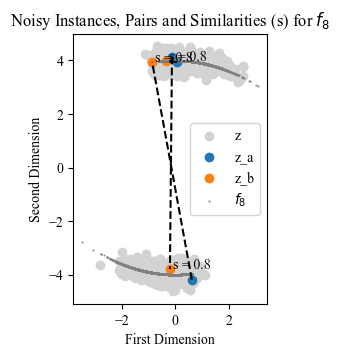

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_8'
def manifold_function(S):
    s_max = np.max(S)
    tmp = np.zeros([len(S),2])
    tmp[S<0,0] = S[S<0] + s_max/6
    tmp[0<=S,0] = S[0<=S] - s_max/6
    tmp[S<0,1] = tmp[S<0,0] **2/10 -4
    tmp[0<=S,1] = -tmp[0<=S,0] ** 2/10 + 4

    return (tmp[:,0], tmp[:,1])

# Generate a dataset
reset_random_number_generators(seed=395) # Reproducability
noise_standard_deviation = [0.2, 0.2]

M = 2**13; N = 2 # Instance count, dimension count
S = np.random.normal(loc=0.0, scale=1.0, size=[M])#np.random.normal(loc=0, scale=1, size=[M])

Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
target_correlations = [0, 0.8]
batch_size = M//8
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

In [13]:
# Create network
reset_random_number_generators(seed=294) # Reproducability
network = create_network(stage_count=5, sigma = 1.0)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [14]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

AttributeError: module 'mathematics' has no attribute 'color_palette'

In [ ]:

# Calibrate network
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=10, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

 6/10 ━━━━━━━━━━━━━━━━━━━━ 3:30 53s/step - Train Loss: 2.3153

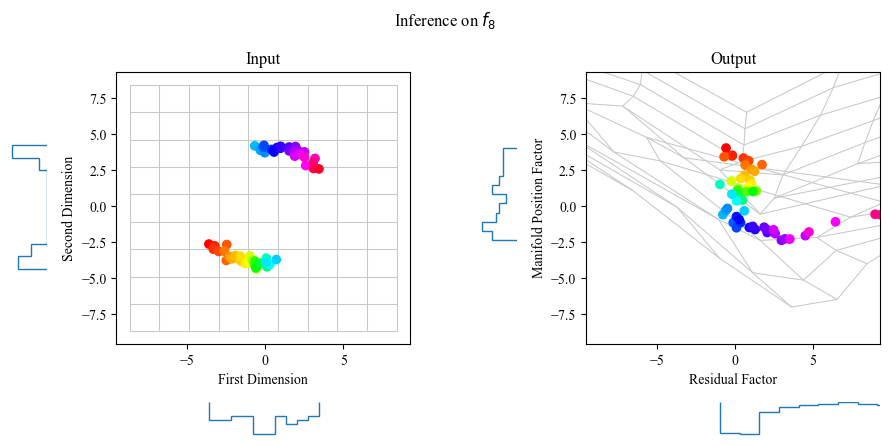

In [116]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=958) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=5, sigma = 0.8)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=50, similarity_function=similarity_function_8, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21,28,35], step_titles=['Stage 1','Stage 2','Stage 3','Stage 4','Stage 5'])

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-2,2,0.1), residual=(-2,2,0.1), S=fixed(S_sample), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name));

Alternatively view video at [https://drive.google.com/file/d/1UB6Ze99AsPjhifZBXYUQrpEHlzb1NYA2/view?usp=share_link](https://drive.google.com/file/d/1UB6Ze99AsPjhifZBXYUQrpEHlzb1NYA2/view?usp=share_link)

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);

## Conclusion

In this notebook, several case studies were constructed to examine the suitability of flow models for factor disentanglement in low dimensional manifolds. It was found that the chosen model can solve rotations, discontinuities, twists, spirals, circles and categorical organization. It was also found that the models makes use of affine as well as higher order transformations, suggesting that all layer types are useful. During experimentation it was found that model size matters for performance. The majority of case studies yielded reliable solutions across partitions of their data sets. In a nutshell one may conclude that the model is versatile for solving the low-dimensional manifold position problem. It remains to be investigated how this potential translates to higher dimensional spaces.